# Packages

In [72]:
import numpy as np

import os
import sys
import matplotlib.pyplot as plt
import scipy
import time
import copy as cp
import inspect
import types
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy import signal
from scipy import linalg, interpolate
from scipy.ndimage import gaussian_filter1d

# import necessary stuff from quidi
from logic.pulsed.pulse_objects import PulseBlock, PulseBlockEnsemble, PulseSequence
from logic.pulsed.sampling_functions import DDMethods
from user_scripts.Timo.own.optimalcontrol.oc_simlib import TimeDependentSimulation, SimParameters, ArbPulse, PredefinedArbPulses

import logging
logging.basicConfig(filename='logfile.log', filemode='w', level=logging.DEBUG)
logger = logging.getLogger(__name__)

from PyQt5.QtGui import QGuiApplication
from datetime import datetime as datetime_, timedelta

0

0

In [2]:
pulsedmeasurementlogic.pulsegenerator().get_sample_rate()

25000000000.0

# Library functions

## this nb

In [6]:

def qWait(t_ms):
    end = datetime_.now() + timedelta(milliseconds=t_ms)
    while datetime_.now() < end:
        QGuiApplication.processEvents()
def list_2_csv(in_list):
    str_list = ""
    
    if type(in_list) != list:
        in_list = [in_list]
        
    for el in in_list:
        str_list += f"{el}, "
    
    if len(str_list) > 0:
        str_list = str_list[:-2]
        
    return str_list

def dict_2_header_str(in_dict):
    out_str = ""
    for key, val in in_dict.items():
        out_str += f"{key}: {val}\n"
        
    return out_str

def get_pulse_filename(path, name="", name_ampl="amplitude.txt", name_phase="phase.txt"):
    return os.path.abspath(path + "/" + name + name_ampl), os.path.abspath(path + "/" + name + name_phase)

def lambda_2_str(func):
    if type(func) is types.FunctionType:
        try:
            funcString = inspect.getsourcelines(func)[0][0]
            funcString.strip("['\n']").split("=")[1]
            return funcString
        except IndexError:
            return str(func) + '_LAMBDA_CONV_FAIL'
    else:
        raise ValueError("")

def save_pulse(path, data_ampl, data_phase, name="", name_ampl="amplitude.txt", name_phase="phase.txt"):
    header_dict = {}
    
    def _lambda_2_str(dict_in):
        dict_out = cp.deepcopy(dict_in)
        for key, val in dict_in.items():
            if type(val) is types.FunctionType:
                funcString = lambda_2_str(val)
                dict_out[key] = funcString
        
        return dict_out
    
    try:
        now = datetime.datetime.now() # current date and time
        header_dict['timestamp'] = now.strftime("%Y/%m/%d-%H:%M:%S")
        header_dict['script_parameters'] = _lambda_2_str(script_params)
        header_dict.update(opti_comm_dict['optimization_dictionary'])
        
        fname_ampl, fname_phase = get_pulse_filename(path, name=name, name_ampl=name_ampl, name_phase=name_phase)
        
        if data_ampl is not None:
            try:
                os.remove(fname_ampl)
            except IOError:
                pass
            np.savetxt(fname_ampl,  data_ampl,  header=dict_2_header_str(header_dict))
        if data_phase is not None:
            try:
                os.remove(fname_phase)
            except IOError:
                pass
            np.savetxt(fname_phase, data_phase, header=dict_2_header_str(header_dict))
    except:
        logger.exception("")

def pulse_save(path, pulse, name="opt_res_", name_ampl="amplitude.txt", name_phase="phase.txt"):

    t_amplitude = pulse.get_timegrid(unit='s')
    t_phase = pulse.get_timegrid(unit='s')
    amplitude = pulse.get_data_ampl(unit='V')
    phase = pulse.get_data_phase(unit='V')

    data_ampl = np.column_stack((t_amplitude, amplitude))
    data_phase = np.column_stack((t_phase, phase))

    save_pulse(path, data_ampl, data_phase, name=name, name_ampl=name_ampl, name_phase=name_phase)

        
def save_optimization_result(path, name="opt_res_", name_ampl="amplitude.txt", name_phase="phase.txt"):
    try:
        # save fom by same function as pulse
        save_pulse(path, fom_all, None, name=name, name_ampl='fom.txt', name_phase='')
        
        # save best pulse
        pulse = get_pulse_from_logic(get_best=True)
        t_amplitude = pulse.get_timegrid(unit='s')
        t_phase = pulse.get_timegrid(unit='s')
        amplitude = pulse.get_data_ampl(unit='V')
        phase = pulse.get_data_phase(unit='V')
        
        data_ampl = np.column_stack((t_amplitude, amplitude))
        data_phase = np.column_stack((t_phase, phase))

        save_pulse(path, data_ampl, data_phase, name=name, name_ampl=name_ampl, name_phase=name_phase)

    except:
        logger.exception("")
        
def interpolate_2_timegrid(pulse, timegrid_new, timegrid_unit='s'):
    """
    Put pulse on new timegrid. 
    If pulse shorter than new timegrid, zero pad. Else raise.
    """
    amplitude_func = scipy.interpolate.interp1d(pulse.timegrid, pulse.get_data_ampl(unit=pulse.data_unit),
                                                fill_value=0, bounds_error=False)
    phase_func = scipy.interpolate.interp1d(pulse.timegrid, pulse.get_data_phase(unit=pulse.data_unit),
                                            fill_value=0, bounds_error=False)
    
    pulse_new = copy_pulse(pulse)
    if timegrid_unit != pulse.timegrid_unit:
        raise NotImplemented # may rescale the old pulse first
    if timegrid_new[-1] < pulse.timegrid[-1]:
        # this would work, but probably not intended
        raise ValueError("Too short new timegrid would cut pulse.")
    
    pulse_new._data_ampl = amplitude_func(timegrid_new - timegrid_new[0])
    pulse_new._data_phase = phase_func(timegrid_new - timegrid_new[0])
    pulse_new._timegrid_ampl = timegrid_new
    pulse_new._timegrid_phase = timegrid_new
        
    return pulse_new

def scale_power(pulse, factor=1):    
    pulse_new = cp.deepcopy(pulse)
    
    pulse_new._data_ampl = factor*pulse_new._data_ampl
    pulse_new._data_phase = factor*pulse_new._data_phase
    pulse_new._timegrid_ampl = 1/factor*pulse_new._timegrid_ampl
    pulse_new._timegrid_phase = 1/factor*pulse_new._timegrid_phase
    
    # invalidate old data fields
    pulse_new._folder = None
    pulse_new._file = None
    pulse_new._file_ampl = None
    pulse_new._file_phase = None
    
    return pulse_new
    
        

def _get_sine_func(time_array, amplitude_func, frequency, phase_rad, phase_func):
    samples_arr = amplitude_func(time_array - time_array[0]) * np.sin(2*np.pi * frequency * time_array + phase_rad) \
                  + phase_func(time_array - time_array[0]) * np.cos(2*np.pi * frequency * time_array + phase_rad)

    return samples_arr

def sample_pulse(pulse, f_carrier, phase_carrier_rad=0):
    
    timegrid_pulse = pulse.get_timegrid(unit='s')
    t_pulse = timegrid_pulse[-1]
    
    dt_sample = 1/pulsedmeasurementlogic.pulsegenerator().get_sample_rate()
    timegrid_sampling = np.arange(0, t_pulse, dt_sample)
    amplitude = pulse.get_data_ampl(unit='V')
    phase = pulse.get_data_phase(unit='V')

    
    amplitude_func = interpolate.interp1d(timegrid_pulse, amplitude)
    phase_func = interpolate.interp1d(timegrid_pulse, phase)
    samples_arr = _get_sine_func(timegrid_sampling, amplitude_func, f_carrier, phase_carrier_rad, phase_func)
    
    return samples_arr

def get_rescale_factor_ampl(pulse, f_carrier, max_ampl_v=0.25):
    # shaddows qudi::sampling_func
    
    # sampling for the awg has an unknown pulse position and hence phase
    # make sure that the pulse works for all phases by calculating rescale factor for worst case
    phases_rad = np.linspace(0, 2*np.pi, 100)
    samples_arr = sample_pulse(pulse, f_carrier)
    for ph in phases_rad:
        samples_curr = sample_pulse(pulse, f_carrier, phase_carrier_rad=ph)
        if np.max(samples_curr) > np.max(samples_arr):
            samples_arr = samples_curr
            #logger.debug(f"New max pulse ampl {np.max(samples_curr)} for phase {ph/np.pi} pi")
            
    max_sample_before = np.max(samples_arr)
    
    # avoid re-scaling by the pg, todo: think of better way
    import scipy
    if max(abs(samples_arr)) > 0.25:
        biggest_val = max([abs(np.min(samples_arr)), np.max(samples_arr)])
        mapper = scipy.interpolate.interp1d([-biggest_val, biggest_val], [-max_ampl_v, max_ampl_v])
        samples_arr = mapper(samples_arr)
        
    max_samples_after = np.max(samples_arr)
    
    return max_samples_after/max_sample_before
    
        
def get_pulse_from_logic(get_best=False):
    
    if get_best:
        optimizer_obj = optimizationlogic.optimization_obj
        best_dict = optimizer_obj.opt_alg_obj.get_best_controls()

        pulses, timegrids, parameters = best_dict['pulses'], best_dict['timegrids'], best_dict['parameters']
    else:
        pulses, parameters, timegrids = controlslogic.pulses, controlslogic.parameters, controlslogic.timegrids
    
    # save pulse as raw from logic
    fname_tmp = '.tmp_pulse_'
    fname_tmp_ampl, fname_tmp_ph = get_pulse_filename(folder_path, name=fname_tmp)
    
    data_ampl = np.column_stack((timegrids[0], pulses[0]))
    data_phase = np.column_stack((timegrids[0], pulses[1]))
    save_pulse(folder_path, data_ampl, data_phase, name=fname_tmp)
    
    # reload as a pulse object
    pulse = ArbPulse.load_pulse(folder_path, fname_tmp, unit_t='s', unit_data='V')
    os.remove(fname_tmp_ampl)
    os.remove(fname_tmp_ph)
    
    fac = get_rescale_factor_ampl(pulse, f_res, max_ampl_v=ampl_max)
    if fac != 1:
        logger.warning(f"Rescaling pulses with fac={fac} prior to saving and sampling.")
    
    pulse._data_ampl  = fac*pulse._data_ampl
    pulse._data_phase = fac*pulse._data_phase
    
    return pulse

# todo: to lib
def copy_pulse(pulse):
    """
    (deep) copy pulse. Keep data.
    """
    pulse_new = cp.deepcopy(pulse)

    # invalidate old data fields
    pulse_new._folder = None
    pulse_new._file = None
    pulse_new._file_ampl = None
    pulse_new._file_phase = None

    return pulse_new

# todo: to lib
def shift_phase(pulse, phi_rad):
      
    pulse_new = copy_pulse(pulse)
    if phi_rad%(2*np.pi)==0:
        pass
    elif phi_rad%(2*np.pi)==np.pi/2:
        pulse_new._data_ampl = pulse._data_phase
        pulse_new._data_phase = pulse._data_ampl
    elif phi_rad%(2*np.pi)==np.pi:
        pulse_new._data_ampl = -pulse._data_ampl
        pulse_new._data_phase = -pulse._data_phase
    elif phi_rad%(2*np.pi)==3*np.pi/2:
        pulse_new._data_ampl = -pulse._data_phase
        pulse_new._data_phase = -pulse._data_ampl
    else:
        raise ValueError
    
    return pulse_new


# todo: to lib
def generate_idle(t_idle=10e-9, n_timebins=10):
    idle_pulse = PredefinedArbPulses.generate_rect_pi(1e6, n_t=n_timebins, t_pulse=t_idle)
    idle_pulse.name = 'idle'
    
    idle_pulse._data_ampl[:] = 0
    idle_pulse._data_phase[:] = 0
    idle_pulse._func_ampl_v_2_omega_mhz = lambda x:0*x
    idle_pulse._func_omega_mhz_2_ampl_v = lambda x:0*x
    
    return idle_pulse

def exp_oc_nrep_from_pulse(pulse, t_gap=0e-9, n_rep=1, pi_x_initread=0, omega_rabi_initread=None,
                           dd_type=DDMethods.SE, symmetrize=False):
    if pi_x_initread >0:
        if omega_rabi_initread is None:
            # maximum available Rabi drive in arb pulse
            omega_rabi_initread = np.max([pulse.get_data_ampl(unit="Hz"), pulse.get_data_phase(unit="Hz")])
        init_pulse = PredefinedArbPulses.generate_rect_pi_x(omega_rabi_initread, n_t=len(pulse.timegrid),
                                                           pix=pi_x_initread)
        # assume that calibration of loaded pulse is valid also for new pi2 pulses
        init_pulse._func_ampl_v_2_omega_mhz = pulse._func_ampl_v_2_omega_mhz
        init_pulse._func_omega_mhz_2_ampl_v = pulse._func_omega_mhz_2_ampl_v
    
    if symmetrize:
        idle_pulse = generate_idle(t_gap/2, n_timebins=10)
    else:
        idle_pulse = generate_idle(t_gap, n_timebins=10)
        
    if n_rep == 0:
        return idle_pulse
    

    res_exp = None
    
    for idx in range(n_rep):
        phase_rad = dd_type.phases[idx%dd_type.suborder]/360*(2*np.pi)
        base_block = shift_phase(pulse, phase_rad)
        if t_gap > 0.:
            if symmetrize:
                base_block = ArbPulse.concatenate(idle_pulse, base_block)
                base_block = ArbPulse.concatenate(base_block, idle_pulse)
            else:
                base_block = ArbPulse.concatenate(base_block, idle_pulse)    

            res_exp = ArbPulse.concatenate(res_exp, base_block)
    
    if pi_x_initread>0:
        res_exp = ArbPulse.concatenate(init_pulse, res_exp)
        res_exp = ArbPulse.concatenate(res_exp, init_pulse)
    
    return res_exp
    
def handle_global_gen_params(qmeas):
    """
    If qmeas contains global generation parameters, set them in the sequence generator and delete them from dict.
    Keeping them would provoke an error in the generation method due to unknown kwarg.
    """
    subdict = dict([(key, qmeas.get(key)) for key in pulsedmasterlogic.generation_parameters if key in qmeas])
    pulsedmasterlogic.set_generation_parameters(subdict)
    
    for (key, val) in subdict.items():
        qmeas.pop(key, None)
    
    return subdict

0

0

In [40]:
# qmeas and fom functions
def setup_sts_oc_pi(folder_path, filename, length_oc):
    dictparamsall = pulsedmasterlogic.generate_method_params
    
    dict_qst = dictparamsall["sts_oc"]
    dict_qst["experiment"] = 'sts_oc'
    dict_qst["name"] = 'stsoc'
    dict_qst["length"] = length_oc
    dict_qst["filename_amplitude"] = os.path.basename(get_pulse_filename(folder_path, name=filename)[0])
    dict_qst["filename_phase"] = os.path.basename(get_pulse_filename(folder_path, name=filename)[1])
    dict_qst["folder_path"] = folder_path
    

    
    return dict_qst

def setup_oc_npi(folder_path, filename, length_oc, n_start=1, n_step=1, n_n=4, t_gap=0e-9, phases_oc=[0],
                init_end_pix=0, init_end_phases_deg=[0], symmetrize=True, dd_type=DDMethods.SE,
                alternating_end_phase=False):
    dictparamsall = pulsedmasterlogic.generate_method_params
    
    dict_qst = dictparamsall["oc_nrep"]
    dict_qst["experiment"] = 'oc_nrep'
    dict_qst["name"] = 'oc_nrep'
    dict_qst["filename_amplitude"] = os.path.basename(get_pulse_filename(folder_path, name=filename)[0])
    dict_qst["filename_phase"] = os.path.basename(get_pulse_filename(folder_path, name=filename)[1])
    dict_qst["folder_path"] = folder_path
    
    dict_qst['n_start'] = n_start
    dict_qst['n_step'] = n_step
    dict_qst['t_gap'] = t_gap
    dict_qst['phases'] = list_2_csv(phases_oc)
    dict_qst['init_end_pix'] = init_end_pix
    dict_qst['init_end_phases_deg'] = list_2_csv(init_end_phases_deg)
    dict_qst['num_of_points'] = n_n
    dict_qst["dd_type"] = dd_type
    
    dict_qst["alternating"] = True
    if alternating_end_phase:
        dict_qst["alternating"] = False
        dict_qst["alternating_end_phase"] = True
        
    dict_qst["symmetric_tgap"] = symmetrize
    dict_qst["vs_rect_pulse"] = False
    
    
    return dict_qst

def setup_oc_proctomo(folder_path, filename, length_oc):
    dictparamsall = pulsedmasterlogic.generate_method_params
    
    dict_qst = dictparamsall["qst_state_oc"]
    dict_qst["experiment"] = 'qst_state_oc'
    dict_qst["name"] = 'qststateoc'
    dict_qst["length"] = length_oc
    dict_qst["filename_amplitude"] = os.path.basename(get_pulse_filename(folder_path, name=filename)[0])
    dict_qst["filename_phase"] = os.path.basename(get_pulse_filename(folder_path, name=filename)[1])
    dict_qst["folder_path"] = folder_path
    
    return dict_qst

def setup_sts_oc_cnot(folder_path, filename, length_oc, tau_dd_fix, tau_cnot,
                      dd_type_cnot=DDMethods.SE, dd_order=1,
                      f_mw_2=[], rabi_period_mw_2=[], ampl_mw_2=[]):
    
    # get from common object defined in other notebook
    if f_mw_2 == []:
        f_mw_2 = [common.mw_freq_2[0]]
    if ampl_mw_2 == []:
        ampl_mw_2 = [common.mw_amps_2[0]]
    if rabi_period_mw_2 == []:
        rabi_period_mw_2 = [common.rabi_period_2[0]]
    
    dictparamsall = pulsedmasterlogic.generate_method_params
    
    dict_qst = dictparamsall["tomography_single"]
      
    dict_qst['experiment'] = 'tomography_single'
    dict_qst['name'] = f'sts_cnot'  
    dict_qst['microwave_amplitude'] = common.mw_amp
    dict_qst['microwave_frequency'] = common.mw_freq
    dict_qst['rabi_period'] = common.rabi_period
    
    
    rots = [TomoRotations.c2not1, TomoRotations.c2not1, TomoRotations.c2not1, TomoRotations.c2not1]
    inits = [TomoInit.none, TomoInit.ux180_on_1, TomoInit.ux180_on_2, TomoInit.ux180_on_both]

    dict_qst['rotations'] = str(rots)
    dict_qst['init_states'] = str(inits)
    
    dict_qst['cnot_kwargs'] = {'tau_dd_fix': tau_dd_fix} 
    dict_qst['cnot_kwargs']['env_type'] = Evm.optimal
    dict_qst['tau_cnot'] = tau_cnot
    dict_qst['dd_type_cnot'] = dd_type_cnot
    dict_qst['dd_order'] = dd_order
    dict_qst['alternating'] = True
    

    dict_qst['f_mw_2'] = list_2_csv(f_mw_2)
    dict_qst['rabi_period_mw_2'] = list_2_csv(rabi_period_mw_2)
    dict_qst['ampl_mw_2'] = list_2_csv(ampl_mw_2)            
    
    return dict_qst
    


def setup_fom_func_sts_oc_pi():
    script_params['fom_func_params'] = locals()
    def calc_fom():
        signal_data = pulsedmeasurementlogic.signal_data
        up_norm = signal_data[1,0] / signal_data[1,0]
        down_norm = signal_data[1,1] / signal_data[1,0]

        return np.real(1 - (up_norm - down_norm))
    
    return calc_fom


def setup_fom_func_oc_npi(dd_type=DDMethods.SE):
    script_params['fom_func_params'] = locals()

        
    def calc_fom():
        # signal_data[0,:] = xaxis
        # signal_data[1,:] = yaxis (alternating flattened)
        try:
            signal_data = pulsedmeasurementlogic.signal_data
            #logger.debug(f"Signal: {signal_data}")
            n_pi = len(signal_data[0,:])
            if dd_type is DDMethods.SE:
                fom_perfect = np.tile(np.asarray([0,1]), int(n_pi/2))
            elif dd_type is DDMethods.XY8:
                fom_perfect = np.tile(np.asarray([0,0,1,1,1,0,0,1]), int(n_pi/8))
        
            n_pi_even = np.where(n_pi%2==0)

            data_mw = signal_data[1,:]
            data_alt = signal_data[2,:]
            data_norm = data_mw/data_alt
            data_mw_0 = (data_norm)[fom_perfect==1]  # normed in state |0>
            data_mw_1 = (data_norm)[fom_perfect==0]  # normed in state |1>
            
            err = abs(data_norm - fom_perfect)
            
            logger.debug(f"n_pi={n_pi}, fom_perfect= {fom_perfect}, data= {data_norm}, err= {err}")
            return np.mean(1 - (data_mw_0 - data_mw_1))
        
            #data_mw_0 = (data_norm)[n_pi%2==0]  # normed in state |0>
            #data_mw_1 = (data_norm)[n_pi%2==1]  # normed in state |1>

            #return np.mean(1 - (data_mw_0 - data_mw_1))
        except:
            logger.exception("")
            return np.nan
    
    return calc_fom


def setup_fom_func_sts_cnot():
    script_params['fom_func_params'] = locals()
    # todo: this doesn't norm the data onto some reference contrast (eg. NV1, NV2 -> slow pi on each)
    # do we need norming?
    def calc_fom():
        try:
            signal_data = pulsedmeasurementlogic.signal_data
            #logger.debug(f"Signal: {signal_data}")
            n_pi = len(signal_data[0,:])
            # init= 00, 10, 01, 11
            fom_perfect = np.tile(np.asarray([1,1,-1,1,-1,-1,1,-1]), int(n_pi/8))

            data_mw = signal_data[1,:]
            data_alt = signal_data[2,:]
            data_delta = (data_mw-data_alt)
            data_mw_0 = (data_delta)[fom_perfect==1]  # normed in state |0>
            data_mw_1 = (data_delta)[fom_perfect==-1]  # normed in state |1>
            data_mw_0 = np.pad(data_mw_0, (0,len(data_mw_1) -len(data_mw_0)), mode='constant', constant_values=1)


            err = abs(data_delta - fom_perfect)

            logger.debug(f"n_pi={n_pi}, fom_perfect= {fom_perfect}, data= {data_delta}, err= {err}")
            return np.mean(err)

        except:
            logger.exception("")
            return np.nan
        
    return calc_fom

def _debug_pulse_2_seq(pulse, func_pulse_2_seq=None, **func_kwargs):
    seq = func_pulse_2_seq(pulse, **func_kwargs)
    
    return seq

def setup_fom_simulation_sigz(f_res, func_pulse_2_seq=None, scan_kwarg_key=None, scan_list=[], scan_fom_target=[],
                              **func_kwargs):
    
    script_params['fom_func_params'] = locals()
    
    def fom_func(pulse, func_volt_2_rabi=None):
        # sim units are MHz!
        simp = SimParameters()

        B_gauss = (simp.D - f_res*1e-6)/ simp.gamma_nv

        # copy for safety, data units may change
        pulse_sim = copy_pulse(pulse)
        pulse_sim._func_ampl_v_2_omega_mhz = func_volt_2_rabi
        logger.debug(f"func V->MHz: {func_volt_2_rabi}")
        
        if func_pulse_2_seq is None:
            seqs = [pulse_sim]
        else:
            if scan_kwarg_key is None:
                logger.debug(f"Pulse to seq with params: {func_kwargs}")
                seqs = [func_pulse_2_seq(pulse_sim, **func_kwargs)]
            else:
                seqs = []
                for param_val in scan_list:
                    func_kwargs[scan_kwarg_key] = param_val
                    logger.debug(f"Pulse to seq with params: {func_kwargs}")
                    seqs.append(func_pulse_2_seq(pulse_sim, **func_kwargs))

        try:
            sim = TimeDependentSimulation()

            freq_array = np.asarray([f_res])/1e6  # MHz
            logger.debug(f"Sim at f= {freq_array}")
            pops, foms = [], []
            for idx, seq in enumerate(seqs):
                spin_pop_vs_delta = sim.run_sim_fsweep(freq_array, seq, B_gauss, simp)
                spin_pop = np.mean(spin_pop_vs_delta)
                try:
                    fom = abs(scan_fom_target[idx] - spin_pop)
                    logger.debug(f"Fom= {fom}, diff to target {spin_pop} - {scan_fom_target[idx]}")
                except IndexError:
                    fom = spin_pop
                pops.append(spin_pop)
                foms.append(fom)
                logger.debug(f"=> spin pop {spin_pop}/ fom: {fom}")
                
            fom_res = np.mean(foms)
            logger.debug(f"Foms= {foms}, Total mean fom {fom_res}")
            return fom_res

        except Exception as e:
            logger.exception(f"Couldn't simulate pulse response: ")
            raise
            return np.nan
            
        
    
    return fom_func
    

def get_f_block_sim_array(f_res, f_centers_block, df, n_f, symm_block=False):
    f_centers_block_mhz = 1e-6 * np.asarray(f_centers_block).flatten()
    f_res_mhz = f_res*1e-6
    df_mhz = df*1e-6
    if symm_block:
        deltas = []
        for f_mhz in f_centers_block_mhz:
            deltas.append(abs(f_mhz - f_res_mhz))

        f_centers = []
        for d_mhz in deltas:
            f_center_2_mhz_min = f_res_mhz - d_mhz
            f_center_2_mhz_plus = f_res_mhz + d_mhz
            f_centers.append(f_center_2_mhz_min)
            f_centers.append(f_center_2_mhz_plus)
    else:
        f_centers = f_centers_block_mhz

    freqs = []
    for f in f_centers:
        len_range = int(np.ceil(n_f/len(f_centers)))
        f_range = np.linspace(f-df_mhz, f+df_mhz, len_range)
        logger.debug(f"for f_center= {f}: f_range-f_center= {abs(f_range - f)}")
        if np.min(abs(f_range - f)) > 0.1:
            f_range = np.insert(f_range, 0, f)
        logger.debug(f"adding {f_range}")
        freqs.extend(list(f_range))
    freq_array = 1e6*np.asarray(freqs)

    return freq_array # Hz

def add_penalty_freq_bandstop(fom_func, f_res, f_center_block, df=10e6, n_f_sim=50, fac_penalty=1,
                              symm_block=True, first_fom_req_pulse=False):
    
    script_params['fom_func_params'].update(locals())
    
    def extend_fom(pulse, func_volt_2_rabi=None):
        if first_fom_req_pulse:
            exp_fom = fom_func(pulse, func_volt_2_rabi=func_volt_2_rabi)
        else:
            exp_fom = fom_func()

        # sim units are MHz!
        simp = SimParameters()


        B_gauss = (simp.D - f_res*1e-6)/ simp.gamma_nv

        # copy for safety, data units might change in simulation
        pulse_sim = copy_pulse(pulse)
        pulse_sim._func_ampl_v_2_omega_mhz = func_volt_2_rabi

        try:
            sim = TimeDependentSimulation()
            
            freq_array_mhz = 1e-6*get_f_block_sim_array(f_res, f_center_block, df, n_f_sim, symm_block=symm_block)
            data_freq_detuning = sim.run_sim_fsweep(freq_array_mhz, pulse_sim, B_gauss, simp)
            spin_pop = np.mean(data_freq_detuning)


        except Exception as e:
            logger.exception(f"Couldn't simulate pulse response: ")
            return np.nan

        # in the blockband, spin_pop should be uneffected (=1)
        fom_sim = (1 + fac_penalty*(abs(1-spin_pop)))
        fom_hybrid = exp_fom * fom_sim
        logger.debug(f"FOM: {fom_hybrid} <= Exp: {exp_fom}, Sim: {fom_sim},  factor= {fac_penalty}")
        logger.debug(f"Block bands: {sorted(freq_array_mhz)}, nf= {len(freq_array_mhz)}")
        return fom_hybrid


    return extend_fom


def add_penalty_tomo_freq_bandstop(fom_func, f_res, f_center_block, df=10e6, n_f_sim=50, fac_penalty=1,
                              symm_block=True, first_fom_req_pulse=False):
    
    script_params['fom_func_params'].update(locals())
    

    def extend_fom(pulse, func_volt_2_rabi=None):
        if first_fom_req_pulse:
            exp_fom = fom_func(pulse, func_volt_2_rabi=func_volt_2_rabi)
        else:
            exp_fom = fom_func()

        # sim units are MHz!
        simp = SimParameters()


        B_gauss = (simp.D - f_res*1e-6)/ simp.gamma_nv

        # copy for safety, data units might change in simulation
        pulse_sim = copy_pulse(pulse)
        pulse_sim._func_ampl_v_2_omega_mhz = func_volt_2_rabi

        try:
            freq_array = get_f_block_sim_array(f_res, f_center_block, df, n_f_sim, symm_block=symm_block)
            logger.debug(f"Tomo at delta= {freq_array-f_res}")
            chi_avg =  sim_process_tomo_avg(pulse_sim,  B_gauss, deltas=freq_array-f_res)
            fom = np.real(1 - fidelity_chi_pi_x(chi_avg, u_target='1'))

        except Exception as e:
            logger.exception(f"Couldn't simulate pulse response: ")
            return np.nan

        # in the blockband, spin_pop should be uneffected (=1)
        fom_sim = fac_penalty*fom
        fom_hybrid = exp_fom * fom_sim
        logger.debug(f"FOM: {fom_hybrid} <= Exp: {exp_fom}, Sim: {fom_sim},  factor= {fac_penalty}")
        logger.debug(f"Block bands: {sorted(freq_array)}, nf= {len(freq_array)}")
        return fom_hybrid


    return extend_fom


def setup_fom_func_oc_proctomo(rho_mode='v1'):
    script_params['fom_func_params'] = locals()
    def calc_fom():
        signal_data = pulsedmeasurementlogic.signal_data

        E1 = signal_data[1,2:6]
        E0 = signal_data[1,6:10]
        E2 = signal_data[1,10:14]
        E3 = signal_data[1,14:18]

        # normalize the rabi measurments with m_s=0 and m_s=-1 state measurement
        norm_max = signal_data[1,0]
        norm_min = signal_data[1,1]

        E0 = (E0 - norm_min) / (norm_max-norm_min)
        E1 = (E1 - norm_min) / (norm_max-norm_min)
        E2 = (E2 - norm_min) / (norm_max-norm_min)
        E3 = (E3 - norm_min) / (norm_max-norm_min)

        # calculate the density matrices
        rho0 = calculate_rho(E0)
        rho1 = calculate_rho(E1)
        rho2 = calculate_rho(E2)
        rho3 = calculate_rho(E3)
        
        logger.debug(f"Measured rho {rho0},{rho1},{rho2},{rho3}")
        
        # quadratic maximum likelihood estimation of the density matrices
        rho0_est = rho_phy_corr(rho0)
        rho1_est = rho_phy_corr(rho1)
        rho2_est = rho_phy_corr(rho2)
        rho3_est = rho_phy_corr(rho3)
        
        logger.debug(f"Reconstruted rho {rho0_est},{rho1_est},{rho2_est},{rho3_est}")
        
        if rho_mode == 'v2':
            rho0_est = construct_physical_state(scipy.optimize.minimize(
                RMS_discrepancy_state,x0 = [0,0,1,1,0,0],
                bounds=((-1,1),(-1,1),(-1,1),(0,1),(0,1),(0,1)),
                args=rho0).x)
            rho1_est = construct_physical_state(scipy.optimize.minimize(
                RMS_discrepancy_state,x0 = [0,0,1,1,0,0],
                bounds=((-1,1),(-1,1),(-1,1),(0,1),(0,1),(0,1)),
                args=rho1).x)
            rho2_est = construct_physical_state(scipy.optimize.minimize(
                RMS_discrepancy_state,x0 = [0,0,1,1,0,0],
                bounds=((-1,1),(-1,1),(-1,1),(0,1),(0,1),(0,1)),
                args=rho2).x)
            rho3_est = construct_physical_state(scipy.optimize.minimize(
                RMS_discrepancy_state,x0 = [0,0,1,1,0,0],
                bounds=((-1,1),(-1,1),(-1,1),(0,1),(0,1),(0,1)),
                args=rho3).x)
        
        logger.debug(f"Reconstruted rho_phys {rho0_est},{rho1_est},{rho2_est},{rho3_est}")
        
        # calculate chi matrix (Qunatum Process Tomography)
        chi = calc_chi(rho0_est,rho1_est,rho2_est,rho3_est)
        
        logger.debug(f"Reconstructed process matrix: {chi}")

        # calculate the fom
        fom = np.real(1 - fidelity_chi_pi_x(chi))
        
        return fom
        
    return calc_fom

def setup_fom_simulation_proctomo(f_res, delta_hfs=2.1e6):
    script_params['fom_func_params'] = locals()
    
    def fom_func(pulse, func_volt_2_rabi=None):
        try:
            # sim units are MHz!
            B_gauss = (simp.D - f_res*1e-6)/ simp.gamma_nv
            pulse_sim = copy_pulse(pulse)
            pulse_sim._func_ampl_v_2_omega_mhz = func_volt_2_rabi
            
            chi_avg = sim_process_tomo_avg_hfs(pulse_sim,  B_gauss, delta_hfs=delta_hfs)
            fom = np.real(1 - fidelity_chi_pi_x(chi_avg))

            return fom
        
        except Exception as e:
            logger.exception(f"Couldn't simulate pulse process tomo: ")
            raise
            return np.nan
                
    return fom_func

def setup_fom_simulation_mathematica(f_res1, f_res2, g_dip=15e3, deltas=None, dd_type=DDMethods.XY8, 
                                     dd_order=1, omega_rabi_rect=20e6):
    script_params['fom_func_params'] = locals()
    
    if deltas is None:
        deltas = [0]

    def fom_func(pulse, func_volt_2_rabi=None):
        try:
            
            if dd_type == DDMethods.CPMG:
                dd_params = wolf.evaluate(wsim.loadSequenceCPMG(dd_order))
            elif dd_type == DDMethods.XY8:
                dd_params = wolf.evaluate(wsim.loadSequenceXY8(dd_order))
            else:
                raise NotImplemented("")
            pulse_params = setup_pi_pulse_params('optimal_both')
            
            f_res1_mhz = f_res1/1e6
            f_res2_mhz = f_res2/1e6
            delta_f_mhz = 0#2*np.pi*0.2  # MHz rad
            omega_rabi_mhz = omega_rabi_rect/1e6 # MHz rad
            crosstalk = 1
            
            rhos = []
            
            for delta in deltas:
                delta_f_mhz = delta/1e6
                wsim_params = {'gRun':2*np.pi*g_dip/1e6, 'crossTalkRun':crosstalk,
                               '\u03b41Run':2*np.pi*delta_f_mhz, '\u03b42Run':2*np.pi*delta_f_mhz,
                               '\u03a91max':2*np.pi*omega_rabi_mhz, '\u03a92max':2*np.pi*omega_rabi_mhz,#
                               '\u03c91Run':2*np.pi*f_res1_mhz, '\u03c92Run':2*np.pi*f_res2_mhz,
                              }
                # todo: think of other init states
                qsim = setup_sim_params(dd_params, pi_pulse_params=pulse_params,
                                        init=TomoInit.ux180_on_2, sim_params=wsim_params)
                                
                rho = run_wsim(qsim)

                rhos.append(rho)
                                
                script_params['wolf_sim_params_last'] = qsim
                logger.debug(f"Sim params: {wsim_params.values()}")  # cant display unicode in keys()
                logger.debug(f"For delta= {delta_f_mhz} MHz, rho= {rho}")
                
            rho_avg = sum(rhos)/len(deltas)
            logger.debug(f"Mathematica loaded pulse timestamp: {qsim['wolfram_sim_params']['pulseParamsP1']['fileTimestamp']}")
            logger.debug(f"rho_avg= {rho_avg}")
            
            func_ampl_v_2_2pimhz = qsim['wolfram_sim_params']['pulseParamsP1']['func_ampl_v_2_rabi_2piMHz']
            if func_volt_2_rabi(1)*2*np.pi != func_ampl_v_2_2pimhz:
                raise ValueError(f"ampl_2_rabi calibration does not fit wolfram simulation: {func_ampl_v_2_2pimhz} 2pi MHz")
            file_ampl, file_phase = get_pulse_filename(folder_path, filename)
            file_wolf_ampl, file_wolf_phase = qsim['wolfram_sim_params']['pulseParamsP1']['fileAmpl'], qsim['wolfram_sim_params']['pulseParamsP1']['filePhase']
            if file_wolf_ampl != file_ampl or file_wolf_phase != file_phase:
                raise ValueError(f"File set as file destination {file_ampl} does not fit to the Mathematica loaded: {file_wolf_ampl}")
            
            rho_opt = get_opt_rho(qsim, True)
            # todo: sph_err on NV1 only 
            fidelity, sph_err = state_fidelity(rho_avg, rho_opt), calc_sph_error(rho_avg, qsim)
            fom = abs(1-fidelity)
            return fom
        
        except Exception as e:
            logger.exception(f"Couldn't simulate pulse process tomo: ")
            raise
            return np.nan
                
    return fom_func



0

0

## Others

In [8]:
# shaddows philipp_optimization.ipynb

def calculate_rho(rho_data):
    rho_data[2] = (rho_data[2] - 0.5) * 2
    rho_data[3] = (rho_data[3] - 0.5) * 2
    
    rho_return = np.zeros([2,2], dtype = complex)
    rho_return[0,0] = 1/2 + 1/2 * (rho_data[0] - rho_data[1])
    rho_return[0,1] = 1/2 * (rho_data[3] + 1j * rho_data[2])
    rho_return[1,0] = 1/2 * (rho_data[3] - 1j * rho_data[2])
    rho_return[1,1] = 1/2 - 1/2 * (rho_data[0] - rho_data[1])
    
    return rho_return

def rho_min(rho):
    #find a physically correct density matrix
    
    sigma = np.zeros((2,2))
    # substitute constant values; rho[0,0]) and rho[1,1] are always real!
    a = np.real(1 + (-1 + rho[0,0]) * rho[0,0] + (-1 + rho[1,1]) * rho[1,1] + 2 * np.abs(rho[0,1]))**2
    b = np.real(-rho[0,0] + rho[1,1])
    c = -2 * np.real(rho[0,1])
    d = - 2 * np.imag(rho[0,1])

    n1 = np.arctan2([-c] , [-b])
    n1 = n1[0]
    n2 = np.arctan2([c], [b])
    n2 = n2[0]
    x1 = -np.arccos(- np.sqrt((b**2 + c**2)/(b**2 + c**2 + d**2)))
    x2 = np.arccos(- np.sqrt((b**2 + c**2)/(b**2 + c**2 + d**2)))

    sigma[0,0] = a + b * np.cos(n1) * np.cos(x1) + c * np.cos(x1) * np.sin(n1) + d * np.sin(x1)
    sigma[0,1] = a + b * np.cos(n1) * np.cos(x2) + c * np.cos(x2) * np.sin(n1) + d * np.sin(x2)
    sigma[1,0] = a + b * np.cos(n2) * np.cos(x1) + c * np.cos(x1) * np.sin(n2) + d * np.sin(x1)
    sigma[1,1] = a + b * np.cos(n2) * np.cos(x2) + c * np.cos(x2) * np.sin(n2) + d * np.sin(x2)

    pos_min = np.unravel_index(np.argmin(sigma), np.shape(sigma))
    n_min = int(pos_min[0])
    x_min = int(pos_min[1])

    if n_min == 0 and x_min == 0:
        rho_return = rho_parameterized(n1,x1)
    elif n_min == 0 and x_min == 1:
        rho_return = rho_parameterized(n1,x2)
    elif n_min == 1 and x_min == 0:
        rho_return = rho_parameterized(n2,x1)
    elif n_min == 1 and x_min == 1:
        rho_return = rho_parameterized(n2,x2)
        
    return rho_return

def rho_phy_corr(rho):
    # enforces trace=1
    rho_corr = (rho + np.matrix.getH(rho))/2
    rho_corr = rho_corr/np.trace(rho_corr)
    return rho_corr    

def calc_chi(rho0_chi,rho1_chi,rho2_chi,rho3_chi):
    #"Quantum State Tomography: calculate matrix Chi from given density matrices rho1,..,rho4"
    sigx = np.array([[0,1],[1,0]])

    #Defintion of Matrix M

    M=np.zeros([8,8],dtype=complex)
    M[0,0]=0
    M[0,1]=0
    M[0,2]=0
    M[0,3]=0
    M[0,4]=0
    M[0,5]=0
    M[0,6]=1
    M[0,7]=0

    M[1,0]=0
    M[1,1]=0
    M[1,2]=0
    M[1,3]=0
    M[1,4]=0
    M[1,5]=0
    M[1,6]=0
    M[1,7]=1

    M[2,0]=1
    M[2,1]=0
    M[2,2]=0
    M[2,3]=0
    M[2,4]=0
    M[2,5]=0
    M[2,6]=0
    M[2,7]=0

    M[3,0]=0
    M[3,1]=1
    M[3,2]=0
    M[3,3]=0
    M[3,4]=0
    M[3,5]=0
    M[3,6]=0
    M[3,7]=0

    M[4,0]=0.5
    M[4,1]=0
    M[4,2]=-0.5j
    M[4,3]=0
    M[4,4]=0.5j
    M[4,5]=0
    M[4,6]=0.5
    M[4,7]=0

    M[5,0]=0
    M[5,1]=0.5
    M[5,2]=0
    M[5,3]=-0.5j
    M[5,4]=0
    M[5,5]=0.5j
    M[5,6]=0
    M[5,7]=0.5

    M[6,0]=0.5
    M[6,1]=0
    M[6,2]=-0.5
    M[6,3]=0
    M[6,4]=-0.5
    M[6,5]=0
    M[6,6]=0.5
    M[6,7]=0

    M[7,0]=0
    M[7,1]=0.5
    M[7,2]=0
    M[7,3]=-0.5
    M[7,4]=0
    M[7,5]=-0.5
    M[7,6]=0
    M[7,7]=0.5

    #calculate inverse of matrix M
    Minv = np.linalg.inv(M)
    
    #convert matrices rho1,...,rho4 to one 8x2 matrix
    rho_chi=np.zeros([8,2],dtype=complex)
    rho_chi[0,0]=rho0_chi[0,0]
    rho_chi[0,1]=rho0_chi[0,1]
    rho_chi[1,0]=rho0_chi[1,0]
    rho_chi[1,1]=rho0_chi[1,1]

    rho_chi[2,0]=rho1_chi[0,0]
    rho_chi[2,1]=rho1_chi[0,1]
    rho_chi[3,0]=rho1_chi[1,0]
    rho_chi[3,1]=rho1_chi[1,1]

    rho_chi[4,0]=rho2_chi[0,0]
    rho_chi[4,1]=rho2_chi[0,1]
    rho_chi[5,0]=rho2_chi[1,0]
    rho_chi[5,1]=rho2_chi[1,1]

    rho_chi[6,0]=rho3_chi[0,0]
    rho_chi[6,1]=rho3_chi[0,1]
    rho_chi[7,0]=rho3_chi[1,0]
    rho_chi[7,1]=rho3_chi[1,1]
    
    #Minv times rho
    rhoprime = np.matmul(Minv,rho_chi)
    #convert rhoprime (8x2) into a 4x4 matrix
    rhoM=np.zeros([4,4],dtype=complex)
    rhoM[0:2,0:2]=rhoprime[0:2,0:2]
    rhoM[0:2,2:4]=rhoprime[2:4,0:2]
    rhoM[2:4,0:2]=rhoprime[4:6,0:2]
    rhoM[2:4,2:4]=rhoprime[6:9,0:2]
    
    #Definition of Lambda
    Lambda=np.zeros([4,4],dtype=complex)
    Lambda[0:2,0:2]=np.identity(2)
    Lambda[2:4,0:2]=sigx
    Lambda[0:2,2:4]=sigx
    Lambda[2:4,2:4]=-np.identity(2)
    Lambda = Lambda * 0.5
    
    #calculate Chi
    chi = np.matmul(Lambda,np.matmul(rhoM,Lambda))                    
    
    return chi


def fidelity_chi_pi_x(chi, u_target='x'):
    #"calculate fidelity of Sx pi-pulse"
    #Definition of pauli and spin matrices
    sigx = np.array([[0,1],[1,0]])
    sigy = np.array([[0,-1j],[1j,0]])
    sigz = np.array([[1,0],[0,-1]])

    Sx = 0.5 * sigx
    Sy = 0.5 * sigy
    Sz= 0.5 * sigz

    #initial state
    init1 = np.array([[0,0],[0,1]])
    init2 = np.array([[1,0],[0,0]])
    init3 = np.matmul(np.matmul(linalg.expm(-1j*np.pi/2*Sx),init1),linalg.expm(1j*np.pi/2*Sx))
    init4 = np.matmul(np.matmul(linalg.expm(-1j*np.pi/2*Sy),init1),linalg.expm(1j*np.pi/2*Sy))

    #time evolution operator
    U = linalg.expm(-1j * np.pi * Sx)

    #final state
    final1 = np.matmul(np.matmul(U,init1),U.conj().transpose())
    final2 = np.matmul(np.matmul(U,init2),U.conj().transpose())
    final3 = np.matmul(np.matmul(U,init3),U.conj().transpose())
    final4 = np.matmul(np.matmul(U,init4),U.conj().transpose())
    
    #calculate theoretical chi of Sx pi-pulse
    if u_target == 'x':
        chi_theo = calc_chi(final1,final2,final3,final4)
    elif u_target == '1':
        chi_theo = calc_chi(init1,init2,init3,init4)
    else:
        raise NotImplemented
    
    # calculate figure of merit = gate fidelity
    #fom = np.real(np.trace(np.matmul(chi_theo.conj().transpose(),chi)))
    fom = 1 - 1/4 * np.trace(np.sqrt(np.matmul((chi-chi_theo).conj().transpose(),(chi - chi_theo))))
    
    return fom



# construct a physical state 
def construct_physical_state(params):
    
    # Pauli matrices
    sigma_I = np.array([[1,0],[0, 1]], dtype='complex')
    sigma_x = np.array([[0, 1],[1, 0]], dtype='complex')
    sigma_y = np.array([[0,-1],[1, 0]], dtype='complex') * 1.j
    sigma_z = np.array([[1, 0],[0,-1]], dtype='complex')
    pauli = [sigma_I, sigma_x, sigma_y, sigma_z]


    
    # extract the parameters
    alpha, beta, gamma, a, p_depha, p_depol = params
    
    # starting state (diagonalized)
    rho_phys_0 = np.array([[a,0],[0,1-a]])
    
    # calculate the rotation matrices
    Rot_x = np.array([[np.cos(alpha/2), -1.j*np.sin(alpha/2)],
                      [-1.j*np.sin(alpha/2), np.cos(alpha/2)]])
    Rot_y = np.array([[np.cos(beta/2), -np.sin(beta/2)],
                      [np.sin(beta/2), np.cos(beta/2)]])
    Rot_z = np.array([[np.exp(-1.j*gamma/2), 0],
                      [0, np.exp(1.j*gamma/2)]])
    
    # construct a unitary matrix
    U = np.dot(Rot_z,np.dot(Rot_y,Rot_x))
    
    # unitary transformation
    rho_phys = np.dot(U,np.dot(rho_phys_0,np.matrix.getH(U)))
    
    # consider dephasing
    Kraus_op_depha = []
    Kraus_op_depha.append(np.sqrt(1-p_depha/2) * pauli[0])
    Kraus_op_depha.append(np.sqrt(p_depha/2) * pauli[3])

    rho_tmp = np.zeros((2,2))
    for kk in range(len(Kraus_op_depha)):

        rho_tmp = rho_tmp + np.dot(Kraus_op_depha[kk],
                                   np.dot(rho_phys,np.matrix.getH(Kraus_op_depha[kk])))

    rho_phys = rho_tmp
        
    # consider depolarization
    Kraus_op_depol = []
    Kraus_op_depol.append(np.sqrt(1-3*p_depol/4) * pauli[0])
    Kraus_op_depol.append(np.sqrt(p_depol)/2 * pauli[1])
    Kraus_op_depol.append(np.sqrt(p_depol)/2 * pauli[2])
    Kraus_op_depol.append(np.sqrt(p_depol)/2 * pauli[3])
    
    rho_tmp = np.zeros((2,2))
    for kk in range(len(Kraus_op_depol)):
        rho_tmp = rho_tmp + np.dot(Kraus_op_depol[kk],
                                   np.dot(rho_phys,np.matrix.getH(Kraus_op_depol[kk])))

    rho_phys = rho_tmp
        
    return rho_phys



# minimize the RMS discrepancy and calculate the physical guess for the state
def RMS_discrepancy_state(params, LGST_estimate):
    
    rms_dis_state_arg = LGST_estimate - construct_physical_state(params)
    
    rms_dis_state_val = np.trace(np.dot(np.matrix.getH(rms_dis_state_arg),
                                        rms_dis_state_arg))
        
    return np.real(rms_dis_state_val)


# calculate the physical guess for rho
#construct_physical_state(optimize.minimize(
#    RMS_discrepancy_state,x0 = [0,0,1,1,0,0],
#    bounds=((-1,1),(-1,1),(-1,1),(0,1),(0,1),(0,1)),
#    args=rho_0).x)

0

0

In [9]:
# shaddows philipp_optimization.ipynb

def calculate_rho(rho_data):
    rho_data[2] = (rho_data[2] - 0.5) * 2
    rho_data[3] = (rho_data[3] - 0.5) * 2
    
    rho_return = np.zeros([2,2], dtype = complex)
    rho_return[0,0] = 1/2 + 1/2 * (rho_data[0] - rho_data[1])
    rho_return[0,1] = 1/2 * (rho_data[3] + 1j * rho_data[2])
    rho_return[1,0] = 1/2 * (rho_data[3] - 1j * rho_data[2])
    rho_return[1,1] = 1/2 - 1/2 * (rho_data[0] - rho_data[1])
    
    return rho_return

def rho_min(rho):
    #find a physically correct density matrix
    
    sigma = np.zeros((2,2))
    # substitute constant values; rho[0,0]) and rho[1,1] are always real!
    a = np.real(1 + (-1 + rho[0,0]) * rho[0,0] + (-1 + rho[1,1]) * rho[1,1] + 2 * np.abs(rho[0,1]))**2
    b = np.real(-rho[0,0] + rho[1,1])
    c = -2 * np.real(rho[0,1])
    d = - 2 * np.imag(rho[0,1])

    n1 = np.arctan2([-c] , [-b])
    n1 = n1[0]
    n2 = np.arctan2([c], [b])
    n2 = n2[0]
    x1 = -np.arccos(- np.sqrt((b**2 + c**2)/(b**2 + c**2 + d**2)))
    x2 = np.arccos(- np.sqrt((b**2 + c**2)/(b**2 + c**2 + d**2)))

    sigma[0,0] = a + b * np.cos(n1) * np.cos(x1) + c * np.cos(x1) * np.sin(n1) + d * np.sin(x1)
    sigma[0,1] = a + b * np.cos(n1) * np.cos(x2) + c * np.cos(x2) * np.sin(n1) + d * np.sin(x2)
    sigma[1,0] = a + b * np.cos(n2) * np.cos(x1) + c * np.cos(x1) * np.sin(n2) + d * np.sin(x1)
    sigma[1,1] = a + b * np.cos(n2) * np.cos(x2) + c * np.cos(x2) * np.sin(n2) + d * np.sin(x2)

    pos_min = np.unravel_index(np.argmin(sigma), np.shape(sigma))
    n_min = int(pos_min[0])
    x_min = int(pos_min[1])

    if n_min == 0 and x_min == 0:
        rho_return = rho_parameterized(n1,x1)
    elif n_min == 0 and x_min == 1:
        rho_return = rho_parameterized(n1,x2)
    elif n_min == 1 and x_min == 0:
        rho_return = rho_parameterized(n2,x1)
    elif n_min == 1 and x_min == 1:
        rho_return = rho_parameterized(n2,x2)
        
    return rho_return

def rho_phy_corr(rho):
    # enforces trace=1
    rho_corr = (rho + np.matrix.getH(rho))/2
    rho_corr = rho_corr/np.trace(rho_corr)
    return rho_corr    

def calc_chi(rho0_chi,rho1_chi,rho2_chi,rho3_chi):
    #"Quantum State Tomography: calculate matrix Chi from given density matrices rho1,..,rho4"
    sigx = np.array([[0,1],[1,0]])

    #Defintion of Matrix M

    M=np.zeros([8,8],dtype=complex)
    M[0,0]=0
    M[0,1]=0
    M[0,2]=0
    M[0,3]=0
    M[0,4]=0
    M[0,5]=0
    M[0,6]=1
    M[0,7]=0

    M[1,0]=0
    M[1,1]=0
    M[1,2]=0
    M[1,3]=0
    M[1,4]=0
    M[1,5]=0
    M[1,6]=0
    M[1,7]=1

    M[2,0]=1
    M[2,1]=0
    M[2,2]=0
    M[2,3]=0
    M[2,4]=0
    M[2,5]=0
    M[2,6]=0
    M[2,7]=0

    M[3,0]=0
    M[3,1]=1
    M[3,2]=0
    M[3,3]=0
    M[3,4]=0
    M[3,5]=0
    M[3,6]=0
    M[3,7]=0

    M[4,0]=0.5
    M[4,1]=0
    M[4,2]=-0.5j
    M[4,3]=0
    M[4,4]=0.5j
    M[4,5]=0
    M[4,6]=0.5
    M[4,7]=0

    M[5,0]=0
    M[5,1]=0.5
    M[5,2]=0
    M[5,3]=-0.5j
    M[5,4]=0
    M[5,5]=0.5j
    M[5,6]=0
    M[5,7]=0.5

    M[6,0]=0.5
    M[6,1]=0
    M[6,2]=-0.5
    M[6,3]=0
    M[6,4]=-0.5
    M[6,5]=0
    M[6,6]=0.5
    M[6,7]=0

    M[7,0]=0
    M[7,1]=0.5
    M[7,2]=0
    M[7,3]=-0.5
    M[7,4]=0
    M[7,5]=-0.5
    M[7,6]=0
    M[7,7]=0.5

    #calculate inverse of matrix M
    Minv = np.linalg.inv(M)
    
    #convert matrices rho1,...,rho4 to one 8x2 matrix
    rho_chi=np.zeros([8,2],dtype=complex)
    rho_chi[0,0]=rho0_chi[0,0]
    rho_chi[0,1]=rho0_chi[0,1]
    rho_chi[1,0]=rho0_chi[1,0]
    rho_chi[1,1]=rho0_chi[1,1]

    rho_chi[2,0]=rho1_chi[0,0]
    rho_chi[2,1]=rho1_chi[0,1]
    rho_chi[3,0]=rho1_chi[1,0]
    rho_chi[3,1]=rho1_chi[1,1]

    rho_chi[4,0]=rho2_chi[0,0]
    rho_chi[4,1]=rho2_chi[0,1]
    rho_chi[5,0]=rho2_chi[1,0]
    rho_chi[5,1]=rho2_chi[1,1]

    rho_chi[6,0]=rho3_chi[0,0]
    rho_chi[6,1]=rho3_chi[0,1]
    rho_chi[7,0]=rho3_chi[1,0]
    rho_chi[7,1]=rho3_chi[1,1]
    
    #Minv times rho
    rhoprime = np.matmul(Minv,rho_chi)
    #convert rhoprime (8x2) into a 4x4 matrix
    rhoM=np.zeros([4,4],dtype=complex)
    rhoM[0:2,0:2]=rhoprime[0:2,0:2]
    rhoM[0:2,2:4]=rhoprime[2:4,0:2]
    rhoM[2:4,0:2]=rhoprime[4:6,0:2]
    rhoM[2:4,2:4]=rhoprime[6:9,0:2]
    
    #Definition of Lambda
    Lambda=np.zeros([4,4],dtype=complex)
    Lambda[0:2,0:2]=np.identity(2)
    Lambda[2:4,0:2]=sigx
    Lambda[0:2,2:4]=sigx
    Lambda[2:4,2:4]=-np.identity(2)
    Lambda = Lambda * 0.5
    
    #calculate Chi
    chi = np.matmul(Lambda,np.matmul(rhoM,Lambda))                    
    
    return chi


def fidelity_chi_pi_x(chi, u_target='x'):
    #"calculate fidelity of Sx pi-pulse"
    #Definition of pauli and spin matrices
    sigx = np.array([[0,1],[1,0]])
    sigy = np.array([[0,-1j],[1j,0]])
    sigz = np.array([[1,0],[0,-1]])

    Sx = 0.5 * sigx
    Sy = 0.5 * sigy
    Sz= 0.5 * sigz

    #initial state
    init1 = np.array([[0,0],[0,1]])
    init2 = np.array([[1,0],[0,0]])
    init3 = np.matmul(np.matmul(linalg.expm(-1j*np.pi/2*Sx),init1),linalg.expm(1j*np.pi/2*Sx))
    init4 = np.matmul(np.matmul(linalg.expm(-1j*np.pi/2*Sy),init1),linalg.expm(1j*np.pi/2*Sy))

    #time evolution operator
    U = linalg.expm(-1j * np.pi * Sx)

    #final state
    final1 = np.matmul(np.matmul(U,init1),U.conj().transpose())
    final2 = np.matmul(np.matmul(U,init2),U.conj().transpose())
    final3 = np.matmul(np.matmul(U,init3),U.conj().transpose())
    final4 = np.matmul(np.matmul(U,init4),U.conj().transpose())
    
    #calculate theoretical chi of Sx pi-pulse
    if u_target == 'x':
        chi_theo = calc_chi(final1,final2,final3,final4)
    elif u_target == '1':
        chi_theo = calc_chi(init1,init2,init3,init4)
    else:
        raise NotImplemented
    
    # calculate figure of merit = gate fidelity
    #fom = np.real(np.trace(np.matmul(chi_theo.conj().transpose(),chi)))
    fom = 1 - 1/4 * np.trace(np.sqrt(np.matmul((chi-chi_theo).conj().transpose(),(chi - chi_theo))))
    
    return fom



# construct a physical state 
def construct_physical_state(params):
    
    # Pauli matrices
    sigma_I = np.array([[1,0],[0, 1]], dtype='complex')
    sigma_x = np.array([[0, 1],[1, 0]], dtype='complex')
    sigma_y = np.array([[0,-1],[1, 0]], dtype='complex') * 1.j
    sigma_z = np.array([[1, 0],[0,-1]], dtype='complex')
    pauli = [sigma_I, sigma_x, sigma_y, sigma_z]


    
    # extract the parameters
    alpha, beta, gamma, a, p_depha, p_depol = params
    
    # starting state (diagonalized)
    rho_phys_0 = np.array([[a,0],[0,1-a]])
    
    # calculate the rotation matrices
    Rot_x = np.array([[np.cos(alpha/2), -1.j*np.sin(alpha/2)],
                      [-1.j*np.sin(alpha/2), np.cos(alpha/2)]])
    Rot_y = np.array([[np.cos(beta/2), -np.sin(beta/2)],
                      [np.sin(beta/2), np.cos(beta/2)]])
    Rot_z = np.array([[np.exp(-1.j*gamma/2), 0],
                      [0, np.exp(1.j*gamma/2)]])
    
    # construct a unitary matrix
    U = np.dot(Rot_z,np.dot(Rot_y,Rot_x))
    
    # unitary transformation
    rho_phys = np.dot(U,np.dot(rho_phys_0,np.matrix.getH(U)))
    
    # consider dephasing
    Kraus_op_depha = []
    Kraus_op_depha.append(np.sqrt(1-p_depha/2) * pauli[0])
    Kraus_op_depha.append(np.sqrt(p_depha/2) * pauli[3])

    rho_tmp = np.zeros((2,2))
    for kk in range(len(Kraus_op_depha)):

        rho_tmp = rho_tmp + np.dot(Kraus_op_depha[kk],
                                   np.dot(rho_phys,np.matrix.getH(Kraus_op_depha[kk])))

    rho_phys = rho_tmp
        
    # consider depolarization
    Kraus_op_depol = []
    Kraus_op_depol.append(np.sqrt(1-3*p_depol/4) * pauli[0])
    Kraus_op_depol.append(np.sqrt(p_depol)/2 * pauli[1])
    Kraus_op_depol.append(np.sqrt(p_depol)/2 * pauli[2])
    Kraus_op_depol.append(np.sqrt(p_depol)/2 * pauli[3])
    
    rho_tmp = np.zeros((2,2))
    for kk in range(len(Kraus_op_depol)):
        rho_tmp = rho_tmp + np.dot(Kraus_op_depol[kk],
                                   np.dot(rho_phys,np.matrix.getH(Kraus_op_depol[kk])))

    rho_phys = rho_tmp
        
    return rho_phys



# minimize the RMS discrepancy and calculate the physical guess for the state
def RMS_discrepancy_state(params, LGST_estimate):
    
    rms_dis_state_arg = LGST_estimate - construct_physical_state(params)
    
    rms_dis_state_val = np.trace(np.dot(np.matrix.getH(rms_dis_state_arg),
                                        rms_dis_state_arg))
        
    return np.real(rms_dis_state_val)


# calculate the physical guess for rho
#construct_physical_state(optimize.minimize(
#    RMS_discrepancy_state,x0 = [0,0,1,1,0,0],
#    bounds=((-1,1),(-1,1),(-1,1),(0,1),(0,1),(0,1)),
#    args=rho_0).x)

0

0

# QuOCS and Qudi with Noise

## Creation of the optimization dictionary

The optimization dictionary contains all the settings compulsory for the optimization algorithm in order to run a proper optimization.

In [10]:
optimization_client_name = "test_dCRAB_Noisy_2_control_fields"

optimization_dictionary = {"optimization_client_name": optimization_client_name,
                           'opti_algorithm_module': 'quocslib.optimalalgorithms.dCRABNoisyAlgorithm', 
                           'opti_algorithm_class': 'DCrabNoisyAlgorithm', 
                          }

Number of iteration and super-iterations

In [11]:
# Total number of dCRAB superiteration
super_iteration_number = 10000000
# Maximum number of iteration per super-iteration (in max_eval_total: maximale anzahl von evaluation steps gesamt)
maximum_function_evaluations_number = 500

To activate the drift compensation and the re-evaluation steps add

In [12]:
optimization_dictionary['algorithm_settings'] = {"algorithm_name": "dCRAB",
                                                 "super_iteration_number": super_iteration_number,
                                                 #"max_eval_total": super_iteration_number * maximum_function_evaluations_number,
                                                 "FoM_goal": 0.00001,
                                                 "total_time_lim": 5*48*60,  # minutes
                                                 "compensate_drift": {
                                                     "compensate_after_SI": True,
                                                     "compensate_after_minutes": 4*15
                                                 },
                                                 "random_number_generator":{
                                                     "seed_number":420   # todo: really fix a seed here?
                                                 },
                                                 #"re_evaluation": {
                                                     #"re_evaluation_steps": [0.3, 0.5, 0.51]
                                                 #}
}
optimization_dictionary['algorithm_settings'] 

{'algorithm_name': 'dCRAB', 'super_iteration_number': 10000000, 'FoM_goal': 1e-05, 'total_time_lim': 14400, 'compensate_drift': {'compensate_after_SI': True, 'compensate_after_minutes': 60}, 'random_number_generator': {'seed_number': 420}}

Settings for the inner algorithm used by dCRAB

Make sure that stopping_citeria 'time_limt' is set correctly. Need ~ 100 iterations per super iteration to not move on to next SI to early.

In [13]:
optimization_dictionary['algorithm_settings']["dsm_settings"] = {'general_settings': {
                                                "dsm_algorithm_name": "NelderMead", 
                                                'is_adaptive': False
                                            }, 
                                            'stopping_criteria': {
                                                #"max_eval": 100,
                                                "time_lim": 120,  #min
                                                #"xatol": 1e-10, 
                                                #"frtol": 1e-10,
                                                "change_based_stop": {
                                                    "cbs_funct_evals": 500, 
                                                    "cbs_change": 0.01    # stop if slope below
                                                }
                                            }
}
optimization_dictionary['algorithm_settings']

{'algorithm_name': 'dCRAB', 'super_iteration_number': 10000000, 'FoM_goal': 1e-05, 'total_time_lim': 14400, 'compensate_drift': {'compensate_after_SI': True, 'compensate_after_minutes': 60}, 'random_number_generator': {'seed_number': 420}, 'dsm_settings': {'general_settings': {'dsm_algorithm_name': 'NelderMead', 'is_adaptive': False}, 'stopping_criteria': {'time_lim': 120, 'change_based_stop': {'cbs_funct_evals': 500, 'cbs_change': 0.01}}}}

In [14]:
180/(script_params['runtime_per_epoch']/60)

Traceback (most recent call last):
  File "C:\Software\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-8e7f44ef8d3f>", line 1, in <module>
    180/(script_params['runtime_per_epoch']/60)
NameError: name 'script_params' is not defined


### Times

In [21]:
t_rabi_rect = 50e-9  
pix_pulse = 1
t_oc_pulse = 100.0e-9 #1.0000000000000001e-07
n_timebins = 1000
#t_oc_pulse = timegrid_ampl[-1]
fac_oc_guess = 1.0 # make initial guess not too good, otherwise hard for optimizer

ampl_max = 0.25  # V
ampl_rect = 0.25  # V 


fac_oc_rect = t_oc_pulse/(0.5*t_rabi_rect/pix_pulse)
if fac_oc_rect  < 3:
    logger.warning(f"OC pulse should be >3x as long as rect, now: {t_oc_pulse/(0.5*t_rabi_rect/pix_pulse)}")

time_p = {'time_name': 'time_p', 'initial_value': t_oc_pulse} # pulse length
optimization_dictionary['times'] = [time_p]
optimization_dictionary['oc_pulse_params'] = {'t_rabi_rect': t_rabi_rect, 't_oc_pulse': t_oc_pulse,
                                              'ampl_max': ampl_max, 'ampl_rect': ampl_rect}
ampl_oc_guess = fac_oc_guess*1/fac_oc_rect*ampl_rect


ampl_oc_guess, fac_oc_rect, 1/t_rabi_rect*ampl_max/ampl_rect

(0.0625, 4.0, 20000000.0)

### Parameters

In [16]:
optimization_dictionary['parameters'] = []

In [17]:
optimization_dictionary['times']

[{'time_name': 'time_p', 'initial_value': 1e-07}]

### Pulses

#### Generate from predefined function

Levitt composite pulse

In [100]:
pulse = PredefinedArbPulses.generate_levitt(20e6, n_t=1000)
pulse._func_omega_mhz_2_ampl_v = lambda x: x/20*0.25

from scipy.ndimage import gaussian_filter1d
pulse._data_ampl = gaussian_filter1d(pulse._data_ampl, 5)
pulse._data_phase = gaussian_filter1d(pulse._data_phase, 5)

#pulse.as_dict()

Rect pulse

In [190]:
t_oc_pulse

1e-07

In [188]:
np.linspace(0,t_oc_pulse,10)[-5:]*1e6

array([0.05555556, 0.06666667, 0.07777778, 0.08888889, 0.1       ])

In [172]:
1e3*np.linspace(0,t_oc_pulse)[-1]

9.999999999999999e-05

In [179]:
# pi pulse with fixed lentgh
pulse = PredefinedArbPulses.generate_rect_pi(20e6, n_t=n_timebins, t_pulse=t_oc_pulse)
# hard pi pulse with auto lentgh
pulse = PredefinedArbPulses.generate_rect_pi(10e6, n_t=1000)
pulse._func_omega_mhz_2_ampl_v = lambda x: x/(1e-6/78.2e-9)*0.25
pulse._func_ampl_v_2_omega_mhz = lambda x: x/0.25*(1e-6/78.2e-9)
pulse.set_unit_time('s')
fname = 'dummy' # to make loadable below

pulse.as_dict()
#pulse._timegrid_phase[-1]


{'name': 'rect_phi={phase/np.pi:.1f}pi', 'folder': None, 'file': [], 'timegrid_unit': 's', 'data_unit': 'MHz', 'data_ampl': array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 

#### Load initial guess from extern
... or with fname=None assume slow rect pulse.

In [18]:
#folder = r"C:\Software\qudi_data\optimal_control_assets"
folder = r"C:\Software\qudi_data\optimal_control_assets\20220725_2_lessClipping"
folder = r"C:\Software\qudi_data\optimal_control_assets\20220726_1_NV1_penalty_fac=1"

#fname =  r"on_nv=2_"
fname = r"opt_res_"

# load pulse defined in MHz domain
folder = r"C:\Software\qudi_data\optimal_control_assets\Reisser_MSc_pulse_1"
fname = r"Opt_Pulse_01_"
# ONLY for loading Reisser pulse
pulse = ArbPulse.load_pulse(folder, fname, unit_t='ns', unit_data='MHz',
                            func_ampl_v_2_omega_mhz=lambda x: x/0.25*13.2,
                            func_omega_mhz_2_ampl_v=lambda y: y/13.849* 0.25 * 13.849/13.2)
pulse.set_unit_time('s')
# rescale 20 -> 13.2 MHz
#pulse._data_ampl  = 76.4/49.3*pulse._data_ampl
#pulse._data_phase = 76.4/49.3*pulse._data_phase
#pulse = scale_power(pulse, factor=0.9)
#pulse._func_ampl_v_2_omega_mhz = lambda x: x/0.25*13.2
#pulse._func_omega_mhz_2_ampl_v = lambda y: y/13.849* 0.25 * 13.849/13.2


#folder = r"C:\Software\qudi_data\optimal_control_assets\20220824_1_nv1_onEq_guessFromReisser_pen=10"
#name = "opt_res_"
#name = "opt_res_"
#pulse = ArbPulse.load_pulse(folder, name, unit_t='s', unit_data='V',
#                            func_ampl_v_2_omega_mhz=lambda x: x/0.25*(1e-6/78.2e-9),
#                            )
#pulse = scale_power(pulse, factor=0.9)

# load pulses in V domain (for AWG)
#folder = r"C:\Software\qudi_data\optimal_control_assets\20220726_1_NV1_penalty_fac=1"
#folder = r"C:\Software\qudi_data\optimal_control_assets\Reisser_MSc_pulse_1"
#folder =  r"C:\Software\qudi_data\optimal_control_assets\20220727_1_guessFromReisserMsc"
#folder = r"C:\Software\qudi_data\optimal_control_assets\20220824_1_nv1_onEq_guessFromReisser_pen=10"
#folder = r"C:\Software\qudi_data\optimal_control_assets\20220830_4_nv2_rabiMax=15MHz_guessFromReisser_SimOnly_pen=0"
#fname =  r"on_nv=2_"
#fname = r"opt_res_"
#fname = r"Opt_Pulse_01_"


#folder = r"C:\Software\qudi_data\optimal_control_assets\20220902_7_nv1_onEq_rabiMax=15MHz_fromSim_ocnrep_-1MHz"
#name = "opt_res_"
#name = "opt_res_"
#pulse = ArbPulse.load_pulse(folder, name, unit_t='s', unit_data='V',
#                            func_ampl_v_2_omega_mhz=lambda x: x/0.25*(1e-6/75.72e-9),
#                            )


#pulse = ArbPulse.load_pulse(folder, fname, unit_t='s', unit_data='V')

#pulse = ArbPulse.load_pulse(folder, fname, unit_t='s', unit_data='V')

# rescale amplitude if needed
# BACK rabi/ NOW rabi
#pulse._data_ampl  = 75.72/77.1*pulse._data_ampl
#pulse._data_phase = 75.72/77.1*pulse._data_phase



np.max(pulse._data_ampl), np.max(pulse._data_phase)#, pulse.as_dict()
pulse.name

'Opt_Pulse_01_'

In [19]:
pulse.data_ampl
folder, fname, len(pulse.timegrid)

('C:\\Software\\qudi_data\\optimal_control_assets\\Reisser_MSc_pulse_1', 'Opt_Pulse_01_', 2000)

### Set initial guess

In [23]:
def prep_init_guess_pulse(pulse, fname=None, gauss_filter_n=0):

    len_oc_pulse = optimization_dictionary['times'][0]['initial_value']
    timegrid = np.linspace(0, len_oc_pulse, n_timebins)

    if fname:
        try:        
            pulse = pulse
            logger.info(f"pulse timegrid[-1] {pulse.timegrid[-1]}, timegrid[-1] {timegrid[-1]}")
            pulse = interpolate_2_timegrid(pulse, timegrid)

            
            if gauss_filter_n != 0:
                optimization_dictionary['oc_pulse_params']['init_pulse_gauss_filter_n'] = gauss_filter_n
                pulse._data_ampl = gaussian_filter1d(pulse._data_ampl, gauss_filter_n)
                pulse._data_phase = gaussian_filter1d(pulse._data_phase, gauss_filter_n)

            timegrid_ampl = pulse.get_timegrid(unit='s')

            if n_timebins != len(timegrid_ampl) or not np.isclose(len_oc_pulse,timegrid_ampl[-1]):
                raise RuntimeError(f"Timegrid of loaded init pulse ({timegrid_ampl[-1]}@{len(timegrid_ampl)})"
                                    f"doesn't match settings ({len_oc_pulse}@{n_timebins}) after interpolation" 
                                    f"Unexpected!")
        except:
            logger.exception("")
            fname = None
    if fname:
        try:
            initial_guess_ampl = {'function_type': 'list_function', 'list_function': pulse.get_data_ampl(unit='V')}
            initial_guess_phase = {'function_type': 'list_function', 'list_function': pulse.get_data_phase(unit='V')}
            logger.info(f"Setting {pulse.name}")
        except:
            logger.exception("")
        # ATTENTION: ONLY FOR DEBUG
        #initial_guess_ampl = {'function_type': 'list_function', 'list_function': 1/1.4*pulse['data_ampl']}
        #initial_guess_phase = {'function_type': 'list_function', 'list_function': 1/1.4*pulse['data_phase']}
    else:
        logger.info("No fname")
        pulse = ArbPulse()
        pulse._timegrid_ampl = timegrid
        pulse._timegrid_phase = timegrid
        pulse._data_ampl = np.ones(timegrid.size)*ampl_oc_guess
        pulse._data_phase = np.ones(timegrid.size)*0
        pulse.timegrid_unit = 's'
        pulse.data_unit = 'V'
        pulse.name = 'weak_rect'

        initial_guess_ampl = {'function_type': 'lambda_function', 'lambda_function': f'lambda t: {ampl_oc_guess} + 0.0*t'}
        initial_guess_phase = {'function_type': 'lambda_function', 'lambda_function': f'lambda t: {0} + 0.0*t'}
    
    return pulse, initial_guess_ampl, initial_guess_phase
try:
    pulse, initial_guess_ampl, initial_guess_phase =  prep_init_guess_pulse(pulse, fname=fname, gauss_filter_n=0)
except:
    logger.exception("")
optimization_dictionary['oc_pulse_params']['init_guess_name'] = pulse.name

initial_guess_ampl['function_type'], optimization_dictionary['oc_pulse_params']['init_guess_name']

('list_function', 'weak_rect')

In [24]:
try:
    pulse.get_data_ampl(unit='V')
except:
    logger.exception("")

In [25]:
np.max(pulse.get_data_ampl(unit='V')), len(pulse.timegrid)

(0.0625, 1000)

In [26]:
vec_number = 3   #2-3
upper_freq_lim = 12  #8-12


    
pulse_amplitude = {'pulse_name': 'Amplitude', 
                           'upper_limit':ampl_max, 
                           'lower_limit': -ampl_max, 
                           'bins_number': n_timebins, 
                           'time_name': 'time_p', 
                           'amplitude_variation': 0.5*ampl_oc_guess, # added to guess amp, to create 3 points for start simplex
                           'basis': {'basis_name': 'Fourier', 
                                     'basis_class': 'Fourier', 
                                     'basis_module': 'quocslib.pulses.basis.Fourier', 
                                     'basis_vector_number': vec_number, # number of frequencies within the below defined range
                                     'random_super_parameter_distribution': 
                                     {'distribution_name': 'Uniform', 'distribution_class': 'Uniform', 
                                           'distribution_module': 'quocslib.pulses.superparameter.Uniform', 
                                           'lower_limit': 0.0, 'upper_limit': upper_freq_lim} # number of oscillations within pulse
                                    }, 
                           'scaling_function': {'function_type': 'lambda_function', 'lambda_function': 'lambda t: 1.0 + 0.0*t'}, 
                           'initial_guess': initial_guess_ampl,
                           'shrink_ampl_lim': True
                          }

pulse_phase = {'pulse_name': 'Phase', 
               'upper_limit': ampl_max, 
               'lower_limit': -ampl_max, 
               'bins_number': n_timebins, 
               'time_name': 'time_p', 
               'amplitude_variation': 0.5*ampl_oc_guess, # added to guess amp, to create 3 points for start simplex
               'basis': {'basis_name': 'Fourier', 
                         'basis_class': 'Fourier', 
                         'basis_module': 'quocslib.pulses.basis.Fourier', 
                         'basis_vector_number': vec_number, # number of frequencies within the below defined range
                         'random_super_parameter_distribution': 
                         {'distribution_name': 'Uniform', 'distribution_class': 'Uniform', 
                               'distribution_module': 'quocslib.pulses.superparameter.Uniform', 
                               'lower_limit': 0.0, 'upper_limit': upper_freq_lim} # number of oscillations within pulse
                        }, 
               'scaling_function': {'function_type': 'lambda_function', 'lambda_function': 'lambda t: 1.0 + 0.0*t'}, 
               'initial_guess': initial_guess_phase,
               'shrink_ampl_lim': True
              }

optimization_dictionary['pulses'] = [pulse_amplitude, pulse_phase]

ampl_oc_guess

0.0625

#### Plot Init guess

In [267]:
import matplotlib.pyplot as plt
    
t_amplitude = pulse.get_timegrid(unit='us')
amplitude = pulse.get_data_ampl(unit='V')
t_phase = pulse.get_timegrid(unit='us')
phase = pulse.get_data_phase(unit='V')

max_rabi = np.max([np.max(pulse.get_data_phase(unit='MHz')), np.max(pulse.get_data_ampl(unit='MHz'))])
max_ampl = np.max([np.max(phase), np.max(amplitude)])

try:
    plt.figure(figsize=(10,6))
    plt.plot(t_amplitude, amplitude, label="Ampl (I)")
    plt.plot(t_phase, phase, label="Phase (Q)")
   # plt.plot(t_phase, phase+amplitude, label="
    plt.ylabel("Rabi freq (V)")
    plt.xlabel("time (us)")
    plt.legend(loc='best', prop={'size': 20})
    plt.show()
except:
    logger.exception("")
    
max_ampl, max_rabi

(0.24263120290761014, 12.81728488682568)

Plot samples pulse and check whether amplitude rescaling is needed.

In [268]:
max_old = np.max(sample_pulse(pulse, f_res))

fac = get_rescale_factor_ampl(pulse, f_res, max_ampl_v=ampl_max)
samples = sample_pulse(pulse, f_res)

pulse_new = cp.deepcopy(pulse)
pulse_new._data_ampl  = fac*pulse_new._data_ampl
pulse_new._data_phase = fac*pulse_new._data_phase
samples_new = sample_pulse(pulse_new, f_res)


max_new = np.max(sample_pulse(pulse_new, f_res))


plt.plot(samples, label="old")
plt.plot(samples_new, label=f"rescaled= {fac:.3f}", alpha=0.9)
plt.axhline(ampl_max, color='red', label='AWG limit')
plt.axhline(-ampl_max, color='red')

plt.legend()
plt.show()

np.max(samples), fac

(0.24177415416494452, 1.0)

### Init & Transfer to Qudi-QuOCS

In [62]:
opti_comm_dict = {"optimization_dictionary": optimization_dictionary}
optimizationlogic.load_opti_comm_dict(opti_comm_dict)

Press "Start" in the gui and see whether errors are logged.

Print the optimization dictionary also here. If the GUI is not showing the optimization dictionary, restart the Kernel.

In [63]:
optimalcontrol.opti_comm_dict

{'optimization_dictionary': {'optimization_client_name': 'test_dCRAB_Noisy_2_control_fields', 'opti_algorithm_module': 'quocslib.optimalalgorithms.dCRABNoisyAlgorithm', 'opti_algorithm_class': 'DCrabNoisyAlgorithm', 'algorithm_settings': {'algorithm_name': 'dCRAB', 'super_iteration_number': 10000000, 'FoM_goal': 1e-05, 'total_time_lim': 14400, 'compensate_drift': {'compensate_after_SI': True, 'compensate_after_minutes': 60}, 'random_number_generator': {'seed_number': 420}, 'dsm_settings': {'general_settings': {'dsm_algorithm_name': 'NelderMead', 'is_adaptive': False}, 'stopping_criteria': {'time_lim': 120, 'change_based_stop': {'cbs_funct_evals': 500, 'cbs_change': 0.01}}}}, 'times': [{'time_name': 'time_p', 'initial_value': 1e-07}], 'parameters': [], 'oc_pulse_params': {'t_rabi_rect': 5e-08, 't_oc_pulse': 1e-07, 'ampl_max': 0.25, 'ampl_rect': 0.25, 'init_guess_name': 'weak_rect'}, 'pulses': [{'pulse_name': 'Amplitude', 'upper_limit': 0.25, 'lower_limit': -0.25, 'bins_number': 1000, 't

# Measurement

Run a normal rect Rabi with all analysis and MW generation parameters before. Then run with commented out the dicts below in order to keep all the respective pulsed settings.

In [27]:
script_params = {}
script_params['runtime_per_epoch'] = 4*60#3*60#40  # s
script_params['readout_noise'] = 0.01  # std_dev of fom, controls convergence in iteration
#script_params['readout_noise'] = 1/np.sqrt(2)*0.01  # for n_pi=8, t_gap=0.5us, runtime= 6 mins
# needs to be smaller than the actual pulse length time_p due to the interpolation
script_params['length_oc'] = t_oc_pulse - 1e-9
script_params['is_noisy'] = True

# file paths 
folder_path = r'C:\Software\qudi_data\optimal_control_assets'
filename= "on_nv=1_"

# pg generation settings
p_generation_dict = pulsedmasterlogic.generation_parameters
#p_generation_dict["laser_channel"] = "d_ch2" 
#p_generation_dict["sync_channel"] = "d_ch1" 
#p_generation_dict["gate_channel"] = None#"d_ch1" 
#p_generation_dict["microwave_channel"] = "a_ch1"
#p_generation_dict["microwave_amplitude"] = 0.25
#p_generation_dict["microwave_frequency"] = 2822.3e6
#p_generation_dict["rabi_period"] = 82.7e-9
#p_generation_dict["laser_length"] = 3e-06
#p_generation_dict["laser_delay"] = 0.2e-6
#p_generation_dict["wait_time"] = 1e-06
#p_generation_dict["analog_trigger_voltage"] = 0.0

# load the general measurement parameters for the predefined measurements
pulsedmasterlogic.set_generation_parameters(p_generation_dict)
script_params['pulsed_generation_params'] = pulsedmasterlogic.generation_parameters



script_params['readout_noise'], script_params['pulsed_generation_params']

(0.01, OrderedDict([('laser_channel', 'd_ch4'), ('sync_channel', 'd_ch1'), ('gate_channel', 'd_ch3'), ('microwave_channel', 'a_ch1'), ('microwave_frequency', 2616700000.0), ('microwave_amplitude', 0.25), ('rabi_period', 3.486e-08), ('laser_length', 3e-06), ('laser_delay', 5e-07), ('wait_time', 1e-06), ('analog_trigger_voltage', 0.0), ('optimal_control_assets_path', 'C:\\Software\\qudi_data\\optimal_control_assets')]))

## Set measurement sequence and fom

In [30]:
script_params['pulse_prepare_function'] = None
script_params['fom_func_volt_2_rabi'] = None

qmeas = setup_sts_oc_pi(folder_path, filename, script_params['length_oc'])
qmeas = setup_oc_npi(folder_path, filename, script_params['length_oc'])
# for OC pulse on NV2 (control): from states 0, 1
qmeas = setup_oc_npi(folder_path, filename, script_params['length_oc'], t_gap=0.25/2.1e6, n_n=4)
qmeas = setup_oc_npi(folder_path, filename, script_params['length_oc'], t_gap=1/2.1e6, n_n=8)
#qmeas = setup_oc_npi(folder_path, filename, script_params['length_oc'], t_gap=0, n_n=4)
#qmeas = setup_oc_npi(folder_path, filename, script_params['length_oc'], t_gap=0, n_n=8)

# for OC pulse on NV1 (target): from states X,Y
# todo: IS IT ENOUGH to do pi2X-MWX-pi2X and pi2Y-MWY-pi2Y or do we need pi2X-MWY-pi2X (spin lock)
qmeas = setup_oc_npi(folder_path, filename, script_params['length_oc'], t_gap=1/2.1e6, n_n=8,
                     phases_oc=[0], init_end_pix=0.5, init_end_phases_deg=[0])
                   # phases_oc=[0, 90], init_end_pix=0.5, init_end_phases_deg=[0, 90])
# From simulated ProcTomo: OC pi from ResserMsc is roughly Y pulse
# => need to adapt phases
#qmeas = setup_oc_npi(folder_path, filename, script_params['length_oc'], n_n=4, t_gap=2/2*1/2.1e6, 
#                    #phases_oc=[0,90], init_end_pix=0.5, init_end_phases_deg=[0, 90])
#                     phases_oc=[0], init_end_pix=0.5, init_end_phases_deg=[0])


qmeas['optimize_time'] = 30*60
qmeas['symmetric_tgap'] = True
f_res = script_params['pulsed_generation_params']['microwave_frequency']
f_block = 2717.8e6
fom_func = setup_fom_func_oc_npi()


script_params['fom_func_volt_2_rabi'] = lambda y: y/ampl_rect*(1e-6/t_rabi_rect)
fom_func = add_penalty_freq_bandstop(fom_func, f_res, f_block, fac_penalty=10, symm_block=True)
#fom_func = add_penalty_freq_bandstop(fom_func, f_res, f_block, fac_penalty=1, symm_block=True)

script_params['generate_parameters'] = qmeas
script_params['fom_function'] = fom_func


if t_rabi_rect/script_params['pulsed_generation_params']['rabi_period'] > 1.01 or \
    t_rabi_rect/script_params['pulsed_generation_params']['rabi_period'] < 0.99:
        logger.warning(f"Rabi frequencies set {t_rabi_rect} and read from pused {script_params['pulsed_generation_params']['rabi_period']} are different.")
        #raise ValueError
        
script_params['generate_parameters']

{'name': 'oc_nrep', 'n_start': 1, 'n_step': 1, 'num_of_points': 8, 'filename_amplitude': 'on_nv=1_amplitude.txt', 'filename_phase': 'on_nv=1_phase.txt', 'folder_path': 'C:\\Software\\qudi_data\\optimal_control_assets', 't_gap': 4.761904761904762e-07, 'phases': '0', 'init_end_pix': 0.5, 'init_end_phases_deg': '0', 'dd_type': <DDMethods.SE: [0.0]>, 'vs_rect_pulse': False, 'symmetric_tgap': True, 'alternating': True, 'experiment': 'oc_nrep', 'optimize_time': 1800}

In [255]:
1*1/2.1e6  *1e6
#script_params['pulsed_generation_params']['rabi_period']

0.47619047619047616

In [45]:
# debug fom
try:
    data = script_params['fom_function'](pulse, func_volt_2_rabi=script_params['fom_func_volt_2_rabi'])
except:
    logger.exception("")
    
data

Traceback (most recent call last):
  File "C:\Software\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-4010d76d46eb>", line 7, in <module>
    data
NameError: name 'data' is not defined


## Run

In [276]:
######################################################################################################
# Parameters and Settings
######################################################################################################

# runtime of each experiment
runtime = script_params['runtime_per_epoch']
length_oc = script_params['length_oc'] 

# parameter to stop the experiment if its set to False in the console
pulsedmasterlogic.globalrun = True
uglobals.abort.clear()
logger.info(f"Starting new closed-loop quocs optimization on f_res= {f_res*1e-6} MHz, t_rabi= {1e9*script_params['pulsed_generation_params']['rabi_period']:.1f} ns")

# tell the measurement gui how the sequence looks
pulsed_settings = dict()
pulsed_settings['invoke_settings'] = True
pulsedmasterlogic.set_measurement_settings(pulsed_settings)
script_params['pulsed_settings'] = pulsed_settings


# make sure everything is finished
time.sleep(5)

# how the laser response is analyzed    
#pulsedmasterlogic.set_analysis_settings(method = 'mean')
#pulsedmasterlogic.set_analysis_settings(signal_start = 150e-9)
#pulsedmasterlogic.set_analysis_settings(signal_end = 1e-6)
#pulsedmasterlogic.set_extraction_settings(method = 'conv_deriv')

p_analysis_settings = pulsedmasterlogic.analysis_settings
p_extraction_settings = pulsedmasterlogic.extraction_settings
script_params['pulsed_analysis_settings'] = p_analysis_settings
script_params['pulsed_extraction_settings_settings'] = p_extraction_settings

# array to save the fom evolution
fom_all = []

# This section is devoted to the initialization in the pulsed logic and optimization logic of the main
# settings and parameters to be usde in the creation ofthe pulse sequence and the optimization
# Iteration, controls and figure of merit to compare with QuOCS
# Just an example for debug
args_dict = {"is_noisy": script_params['is_noisy']}
qubit = OneQubit2Fields(args_dict)

######################################################################################################
# Measurement
######################################################################################################
optimalcontrol.start_optimization()

# crucial, maybe it can be much shorter
time.sleep(1)

# Just a time to check for latent time
last_time_fom = time.time()
# repeat the whole process until its manually stopped or QuOCS finsihed the optimization
# Wait few seconds before starting to get and return data
while not optimizationlogic.handle_exit_obj.is_user_running:
    time.sleep(0.1)
    if (time.time() - last_time_fom) > 30 or uglobals.abort.is_set():
        logger.warning("Timeout or abort while initializing quocs.")
        uglobals.abort.set()
        break

# iteration number
it_val = 0

# when did the optimization start?
opt_start_time = time.time()
t_last_optimize = 0
t_last_opt = 0
try:
    # print("Check before the loop starts: {0}".format(optimizationlogic.handle_exit_obj.is_user_running))
    while optimizationlogic.handle_exit_obj.is_user_running == True and not uglobals.abort.is_set():
        time_stamp=time.time()
        # wait until QuOCS optimizes the controls
        # print("Wait until the controls logic gives the controls")
        while not controlslogic.are_pulses_calculated:
            time.sleep(0.1)
            # If the waiting time exceed 10 seconds left stop the optimization
            if time.time() - last_time_fom > 20:
                logger.error("Too much time... Exit!")
                optimizationlogic.handle_exit_obj.is_user_running = False
                break

 
        #######################################################################################################
        # Get the Controls
        #######################################################################################################
        # Change the status of control calculations to avoid to evaluate the fom twice with the same controls
        controlslogic.are_pulses_calculated = False
        pulse = get_pulse_from_logic(get_best=False)
        t_amplitude = pulse.get_timegrid(unit='s')
        t_phase = pulse.get_timegrid(unit='s')
        amplitude = pulse.get_data_ampl(unit='V')
        phase = pulse.get_data_phase(unit='V')
        #######################################################################################################
        # Perform the measurement
        #######################################################################################################

        # save the pulses as .txt files (predefined methods doesn't allow us to upload a numpy array as 
        # parameter)
        data_ampl = np.column_stack((t_amplitude, amplitude))
        data_phase = np.column_stack((t_phase, phase))
        save_pulse(folder_path, data_ampl, data_phase, name=filename)
        save_pulse(folder_path, data_ampl, data_phase, name=filename + f"idx={it_val}_")

        time.sleep(0.5)
        
        qmeas = cp.deepcopy(script_params['generate_parameters'])
        experiment = qmeas['experiment']
        exp_name = qmeas['name']
        try:
            optimize_time = qmeas['optimize_time'] 
        except KeyError:
            optimize_time = None
        qmeas.pop('optimize_time', None)
        qmeas.pop('experiment', None)
        
        #qmeas = set_optimize_time(qmeas, t_last_optimize)
        # generate the sequence
        pulsedmasterlogic.generate_predefined_sequence(experiment,kwarg_dict=qmeas)  

        time.sleep(1)
        if optimize_time:
            if time.time() - t_last_opt > optimize_time:
                # measure a ramsey
                common = common.swap_nvs([2,1])
                qmeas_r = setup_ramsey_params(tau_start, n_tau=80, tau_step=20e-9, alternating=True)
                qmeas_r['measurement_time'] = 2*60
                #run_ramsey(qmeas_r)
                common = common.swap_nvs([1,2])

        # upload the sequence
        pulsedmasterlogic.sample_ensemble(exp_name,True)
        while pulsedmasterlogic.status_dict['sampload_busy'] or pulsedmasterlogic.status_dict['sampling_ensemble_busy'] or pulsedmasterlogic.status_dict['loading_busy']:     
            time.sleep(1)

        #print('Finished uploading', dictparams_oc["name"], '!')

        # make sure everything is finished (crucial)
        #time.sleep(1)#time.sleep(5)    
        
        # optimize/track nv before mes
        if optimize_time:
            if time.time() - t_last_opt > optimize_time:
                #laser_on()
                # laser_on broken, so use sequence on pg
                pulsedmasterlogic.toggle_pulse_generator(True)
                optimize_position()
                #laser_off()
                pulsedmasterlogic.toggle_pulse_generator(False)
                t_last_opt = time.time()
                

                
        # start the measurement
        pulsedmasterlogic.toggle_pulsed_measurement(True)
        time.sleep(1)

        # make sure the measurement started
        while not pulsedmasterlogic.status_dict['measurement_running']:
            time.sleep(0.1)

        measurement_start_time = time.time()

        while time.time() <= measurement_start_time + runtime:
            time.sleep(0.2)

            # option to stop the measurement
            if pulsedmasterlogic.globalrun == False or uglobals.abort.is_set():
                print('Stopping the measurement!')
                break

        # option to stop the measurement
        if pulsedmasterlogic.globalrun == False or uglobals.abort.is_set():
            print('Stopping the measurement!')
            pulsedmasterlogic.toggle_pulsed_measurement(False)
            break

        #time.sleep(1)

        # Stop the measurement
        pulsedmasterlogic.toggle_pulsed_measurement(False)
        time_stamp_mes = time.time()
        

        # Make sure it stopped (Wait until the Picoscope card sends the data)
        while pulsedmasterlogic.status_dict['measurement_running']:
            time.sleep(0.1)

        #######################################################################################################
        # Analysis
        ######################################################################################################

        fom_func = script_params['fom_function']
        if script_params['fom_func_volt_2_rabi'] is None:
            fom = fom_func()
        else:
            pulse = ArbPulse.load_pulse(folder_path, filename, unit_t='s', unit_data='V')
            fom = fom_func(pulse, func_volt_2_rabi=script_params['fom_func_volt_2_rabi'])
        

        fom_all.append([time_stamp_mes, fom])
        it_val += 1
        
        # Update the figure of merit and the standard deviation to the fom logic
        fomlogic.update_fom(fom, script_params['readout_noise'], status_code=0)   # todo: define above
        #fomlogic.update_fom(fom, std, status_code=0)

        # update the last time the fom is calculated
        last_time_fom = time.time()

    # when did the optimization stop?
    opt_end_time = time.time()

    print('It took QuOCS ' + str(opt_end_time-opt_start_time) + ' s to optimize the pulse!')
except:
    logger.exception("")
finally:
    # give a very high fom to the optimization algorithm
    # and status code -1, to interrupt the optimization smoothly
    uglobals.abort.set()
    optimizationlogic.handle_exit_obj.is_user_running = False
    logger.info('Stopping the optimization!')
    fomlogic.update_fom(10**10, status_code=-1)

print("Optimization finished")

In [451]:
fom_all

[0.9919237605415996, 1.1437905508347195]

In [ ]:
len(pulse['timegrid_ampl'])

## Test FOM noise

In [124]:
script_params['runtime_per_epoch'], script_params['generate_parameters']['filename_amplitude']

(60, 'on_nv=1_amplitude.txt')

In [154]:
uglobals.abort.clear()

# ATTENTION: need to make sure that the right files are here. QuOCS won't generator for you!
assets_folder = r"C:\Software\qudi_data\optimal_control_assets"

runtime = script_params['runtime_per_epoch']
length_oc = script_params['length_oc'] 

p_generation_dict = pulsedmasterlogic.generation_parameters
# load the general measurement parameters for the predefined measurements
pulsedmasterlogic.set_generation_parameters(p_generation_dict)
script_params['pulsed_generation_params'] = pulsedmasterlogic.generation_parameters


pulsed_settings = dict()
pulsed_settings['invoke_settings'] = True
pulsedmasterlogic.set_measurement_settings(pulsed_settings)
script_params['pulsed_settings'] = pulsed_settings

fom_all =  []
n_mc = 20
idx= 0

logger.info("Starting new FOM noise test")


try:
    while idx<n_mc and not uglobals.abort.is_set():
        time_stamp=time.time()

        qmeas = cp.deepcopy(script_params['generate_parameters'])
        experiment = qmeas['experiment']
        exp_name = qmeas['name']
        qmeas.pop('experiment', None)
        # generate the sequence
        pulsedmasterlogic.generate_predefined_sequence(experiment,kwarg_dict=qmeas)  

        time.sleep(1)

        # upload the sequence
        pulsedmasterlogic.sample_ensemble(exp_name,True)
        while pulsedmasterlogic.status_dict['sampload_busy'] or pulsedmasterlogic.status_dict['sampling_ensemble_busy'] or pulsedmasterlogic.status_dict['loading_busy']:     
            time.sleep(1)

        #print('Finished uploading', dictparams_oc["name"], '!')

        # make sure everything is finished (crucial)
        #time.sleep(1)#time.sleep(5)    

         # start the measurement
        #print('Starting the measurement!')
        pulsedmasterlogic.toggle_pulsed_measurement(True)
        time.sleep(1)

        # make sure the measurement started
        while not pulsedmasterlogic.status_dict['measurement_running']:
            time.sleep(0.1)

        measurement_start_time = time.time()

        while time.time() <= measurement_start_time + runtime:
            time.sleep(0.2)

            # option to stop the measurement
            if uglobals.abort.is_set():
                print('Stopping the measurement!')
                break

        # option to stop the measurement
        if uglobals.abort.is_set():
            print('Stopping the measurement!')
            pulsedmasterlogic.toggle_pulsed_measurement(False)
            break

        #time.sleep(1)

        # Stop the measurement
        pulsedmasterlogic.toggle_pulsed_measurement(False)
        time_stamp_mes = time.time()

        # Make sure it stopped (Wait until the Picoscope card sends the data)
        while pulsedmasterlogic.status_dict['measurement_running']:
            time.sleep(0.1)

        #######################################################################################################
        # Analysis
        ######################################################################################################

        fom_func = script_params['fom_function']
        if script_params['fom_func_volt_2_rabi'] is None:
            fom = fom_func()
        else:
            # fom that includes a simulated penalty
            pulse = ArbPulse.load_pulse(folder_path, filename, unit_t='s', unit_data='V')
            fom = fom_func(pulse, func_volt_2_rabi=script_params['fom_func_volt_2_rabi'])
           
        fom_all.append([time_stamp_mes, fom])
        
        idx += 1
except:
    logger.exception("")

In [155]:
foms = np.asarray(fom_all)
foms

array([[1.66152313e+09, 1.90721846e+00],
       [1.66152320e+09, 1.91375053e+00],
       [1.66152328e+09, 1.90798242e+00],
       [1.66152335e+09, 1.88180917e+00],
       [1.66152342e+09, 1.86708771e+00],
       [1.66152350e+09, 1.93041204e+00],
       [1.66152357e+09, 1.90889613e+00],
       [1.66152364e+09, 1.87845970e+00],
       [1.66152371e+09, 1.94612294e+00],
       [1.66152378e+09, 1.85930624e+00],
       [1.66152386e+09, 1.93951109e+00],
       [1.66152393e+09, 1.90281609e+00],
       [1.66152400e+09, 1.87605559e+00],
       [1.66152407e+09, 1.90941458e+00],
       [1.66152414e+09, 1.91461101e+00],
       [1.66152422e+09, 1.90343067e+00],
       [1.66152429e+09, 1.89295560e+00],
       [1.66152436e+09, 1.89426307e+00],
       [1.66152443e+09, 1.87506257e+00],
       [1.66152450e+09, 1.93600918e+00]])

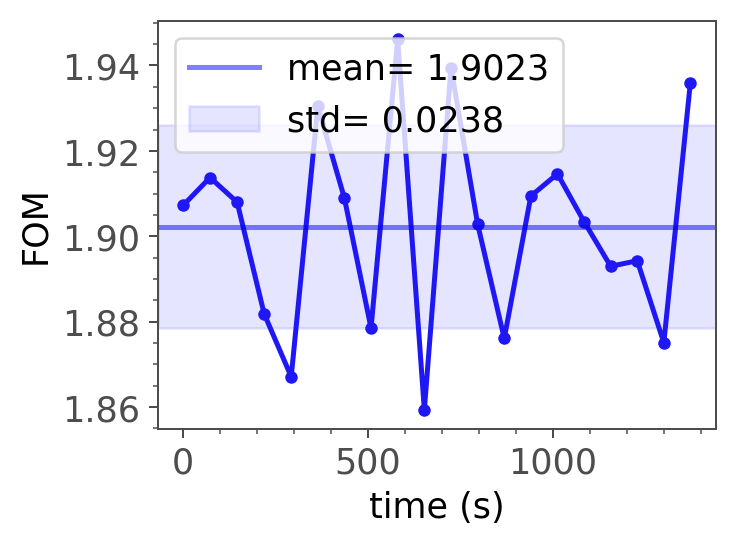

In [129]:
np.mean(foms[:,1]), np.std(foms[:,1])

(0.9464527585971627, 0.011418977900333992)

## Save the results

Currently need to hiz "stop" in optimalcontrol gui manually

In [254]:
try:
    save_optimization_result(folder_path)
except:
    logger.exception("")

In [ ]:
try:
    optimizer_obj = optimizationlogic.optimization_obj
    optimizer_obj.get_optimization_algorithm()
except:
    logger.exception("")

In [ ]:
optimizer_obj.__dict__

In [ ]:
pulses_list, time_grids_list, parameters_list = optimizer_obj.opt_alg_obj.get_best_controls()

t_amplitude = time_grids_list[0]
amplitude = pulses_list[0]
t_phase = time_grids_list[1]
phase = pulses_list[1]

In [ ]:
best_dict = optimizer_obj.opt_alg_obj.get_best_controls()

pulses_list = best_dict['pulses']
time_grids_list = best_dict['timegrids']
parameters_list = best_dict['parameters']

pulses_list

In [ ]:
optimizer_obj.opt_alg_obj.get_best_controls().keys()

In [749]:
pulse = get_pulse_from_logic(get_best=True)

optimizer_obj = optimizationlogic.optimization_obj
best_dict = optimizer_obj.opt_alg_obj.get_best_controls()
pulses, timegrids, parameters = best_dict['pulses'], best_dict['timegrids'], best_dict['parameters']
  

data_ampl = np.column_stack((timegrids[0], pulses[0]))
data_phase = np.column_stack((timegrids[0], pulses[1]))

best_dict['pulses']

[array([ 0.14656046,  0.15218134,  0.15775545,  0.16326872,  0.16870821,
        0.17406169,  0.17931722,  0.18446285,  0.18948629,  0.19437488,
        0.19911551,  0.20369473,  0.2080989 ,  0.2123144 ,  0.21632778,
        0.22012598,  0.2236964 ,  0.22702713,  0.23010692,  0.23292538,
        0.23547291,  0.23774086,  0.23972147,  0.24140794,  0.24279446,
        0.24387617,  0.24464925,  0.24511084,  0.24525909,  0.24509315,
        0.24461315,  0.24382018,  0.24271627,  0.24130441,  0.23958846,
        0.23757316,  0.23526409,  0.23266763,  0.22979091,  0.22664177,
        0.22322875,  0.21956097,  0.21564814,  0.21150049,  0.2071287 ,
        0.20254387,  0.19775743,  0.19278112,  0.18762691,  0.18230695,
        0.17683349,  0.17121886,  0.1654754 ,  0.15961538,  0.15365098,
        0.14759422,  0.14145691,  0.13525061,  0.12898657,  0.12267571,
        0.11632855,  0.1099552 ,  0.10356531,  0.09716804,  0.09077203,
        0.08438539,  0.07801567,  0.07166984,  0.06535428,  0.0

In [761]:
optimizer_obj.opt_alg_obj._get_final_results()

{'Figure of merit': 0.5351242162190543, 'Std': 0.0, 'total number of function evaluations': 2150, 'dcrab_freq_list': [array([[ 1.26258366,  5.81212271,  9.06792906],
       [ 0.43571273,  7.47266592, 10.51891407]]), array([[ 3.07031968,  7.45406655, 11.11048191],
       [ 0.90360062,  7.04155686,  9.76554149]]), array([[3.7532004 , 4.18917789, 8.00876221],
       [1.38549865, 6.71189548, 9.25646082]]), array([[2.17345659, 6.35884163, 8.92658767],
       [0.04530831, 6.91320574, 8.20458014]]), array([[0.60769751, 6.32291478, 8.75718807],
       [1.32483614, 5.56960255, 9.68929558]]), array([[3.71604241, 7.86638063, 8.75802141],
       [3.85689196, 6.59565936, 8.95446073]]), array([[0.92144038, 5.22448392, 9.61629154],
       [3.75665776, 4.72278585, 8.77776836]]), array([[ 0.25502529,  4.4984165 ,  9.66045407],
       [ 0.59546606,  7.54378213, 10.36042675]]), array([[0.18758619, 4.56695948, 9.00791375],
       [1.31743515, 6.97953289, 8.769438  ]]), array([[ 2.35923948,  7.40088684,  9

## manually extract best pulse from result log

In [ ]:
path = r"C:\Software\qudi_data\optimal_control_assets\20220724_1\20220723_202625_test_dCRAB_Noisy_2_control_fields"
file = r"20220723_202625_best_controls"
pulse = TimeDependentSimulation.load_pulse(path, file, extension='npz')

#path = r"C:\Software\qudi_data\optimal_control_assets\20220724_1"
#file = r"on_nv=2_"
#pulse = load_pulse(path, file, extension='txt')

pulse

In [ ]:
import matplotlib.pyplot as plt
    
t_amplitude = pulse['timegrid_ampl']
amplitude = pulse['data_ampl']
t_phase = pulse['timegrid_phase']
phase = pulse['data_phase']

try:
    plt.plot(t_amplitude*1e9, amplitude, label="Ampl (I)")
    plt.plot(t_phase*1e9, phase, label="Phase (Q)")
    plt.xlabel("time (ns)")
    plt.legend()
    plt.show()
except:
    logger.exception("")

In [ ]:
path = folder_path
name = "opt_pulse_"

data_ampl = np.column_stack((t_amplitude, amplitude))
data_phase = np.column_stack((t_phase, phase))

save_pulse(path, data_ampl, data_phase, name=name)


## Simulation only

Setup a fom that simulates and quantifies pulse reponse. Currently,
1. Simulate pi pulse/ 1 qubit, sigma_z
2. Simualte pi pulse/ 1 qubit, process tomo
3. (BUGGY) Simulate sequence of pi pulses / 1 qubit
4. Simulate crosstalk / add penalty
5. Simulate wolfram gate perforamnce

Then use "run simulation" below to start optimization via qudi/quocs

In [56]:
script_params['readout_noise'] = 0

script_params['fom_func_volt_2_rabi'] = lambda y: y/ampl_rect*(1e-6/t_rabi_rect)

# sigma z
fom_func = setup_fom_simulation_sigz(f_res)
# process tomography
fom_func = setup_fom_simulation_proctomo(f_res, delta_hfs=2.1e6)

#fom_func = add_penalty_freq_bandstop(fom_func, f_res, f_block, fac_penalty=100, n_f_sim=75, 
#                                     symm_block=True, first_fom_req_pulse=True)

fom_func = add_penalty_tomo_freq_bandstop(fom_func, f_res, f_block, fac_penalty=100, n_f_sim=25, 
                                     symm_block=True, first_fom_req_pulse=True, df=5e6) # True


script_params['fom_function'] = fom_func

script_params['readout_noise'], f_res, f_block, (f_res-f_block)/1e6

(0, 2616700000.0, 2717800000.0, -101.1)

### Simulate first guess

In [57]:
fom_func = script_params['fom_function']

fom = -1
if script_params['fom_func_volt_2_rabi'] is None:
    fom = fom_func()
else:
    #pulse = ArbPulse.load_pulse(folder_path, filename, unit_t='s', unit_data='V')
    fom = fom_func(pulse, func_volt_2_rabi=script_params['fom_func_volt_2_rabi'])

fom,  fom_func

(3.1316337083965444, <function add_penalty_tomo_freq_bandstop.<locals>.extend_fom at 0x0000000579E421E0>)

In [58]:
script_params['fom_func_volt_2_rabi'] 

<function <lambda> at 0x0000000579E8D488>

In [74]:
get_pulse_from_logic()

### Run Sim Optimization

In [ ]:
#f_res = script_params['pulsed_generation_params']['microwave_frequency']
try:
    script_params['fom_func_volt_2_rabi'] = lambda y: y/ampl_rect*(1e-6/t_rabi_rect)



    ######################################################################################################
    # Parameters and Settings
    ######################################################################################################

    # runtime of each experiment
    runtime = script_params['runtime_per_epoch']
    length_oc = script_params['length_oc'] 

    # parameter to stop the experiment if its set to False in the console
    pulsedmasterlogic.globalrun = True
    uglobals.abort.clear()
    logger.info("Starting new closed-loop quocs optimization")


    # array to save the fom evolution
    fom_all = []

    # This section is devoted to the initialization in the pulsed logic and optimization logic of the main
    # settings and parameters to be usde in the creation ofthe pulse sequence and the optimization
    # Iteration, controls and figure of merit to compare with QuOCS
    # Just an example for debug
    args_dict = {"is_noisy": script_params['is_noisy']}
    qubit = OneQubit2Fields(args_dict)

    ######################################################################################################
    # Measurement
    ######################################################################################################
    optimalcontrol.start_optimization()

    # crucial, maybe it can be much shorter
    time.sleep(1)

    # Just a time to check for latent time
    last_time_fom = time.time()
    # repeat the whole process until its manually stopped or QuOCS finsihed the optimization
    # Wait few seconds before starting to get and return data
    while not optimizationlogic.handle_exit_obj.is_user_running:
        time.sleep(0.1)
        if (time.time() - last_time_fom) > 30 or uglobals.abort.is_set():
            logger.warning("Timeout or abort while initializing quocs.")
            uglobals.abort.set()
            break

    # iteration number
    it_val = 0

    # when did the optimization start?
    opt_start_time = time.time()
    try:
        # print("Check before the loop starts: {0}".format(optimizationlogic.handle_exit_obj.is_user_running))
        while optimizationlogic.handle_exit_obj.is_user_running == True and not uglobals.abort.is_set():
            time_stamp=time.time()
            # wait until QuOCS optimizes the controls
            # print("Wait until the controls logic gives the controls")
            while not controlslogic.are_pulses_calculated:
                qWait(100)
                # If the waiting time exceed 10 seconds left stop the optimization
                if time.time() - last_time_fom > 20:
                    logger.error("Too much time... Exit!")
                    optimizationlogic.handle_exit_obj.is_user_running = False
                    break


            #######################################################################################################
            # Get the Controls
            #######################################################################################################
            # Change the status of control calculations to avoid to evaluate the fom twice with the same controls
            controlslogic.are_pulses_calculated = False
            # Get the controls from the controls logic
            pulse = get_pulse_from_logic(get_best=False)
            t_amplitude = pulse.get_timegrid(unit='s')
            t_phase = pulse.get_timegrid(unit='s')
            amplitude = pulse.get_data_ampl(unit='V')
            phase = pulse.get_data_phase(unit='V')
            #######################################################################################################
            # Perform the measurement
            #######################################################################################################

            # save the pulses as .txt files (predefined methods doesn't allow us to upload a numpy array as 
            # parameter)
            data_ampl = np.column_stack((t_amplitude, amplitude))
            data_phase = np.column_stack((t_phase, phase))
            save_pulse(folder_path, data_ampl, data_phase, name=filename)
            save_pulse(folder_path + '/tmp_pulses', data_ampl, data_phase, name=filename + f"idx={it_val}_")

            qWait(500)


            measurement_start_time = time.time()

            # option to stop the measurement
            if pulsedmasterlogic.globalrun == False or uglobals.abort.is_set():
                print('Stopping the measurement!')
                break


            #######################################################################################################
            # Analysis
            ######################################################################################################

            fom_func = script_params['fom_function']
            if script_params['fom_func_volt_2_rabi'] is None:
                fom = fom_func()
            else:
                pulse = ArbPulse.load_pulse(folder_path, filename, unit_t='s', unit_data='V')
                fom = fom_func(pulse, func_volt_2_rabi=script_params['fom_func_volt_2_rabi'])

            fom += np.random.normal(0, script_params['readout_noise'])
            fom = abs(fom)

            fom_all.append(fom)

            # Update the figure of merit and the standard deviation to the fom logic
            fomlogic.update_fom(fom, script_params['readout_noise'], status_code=0)   # todo: define above
            #fomlogic.update_fom(fom, std, status_code=0)

            # update the last time the fom is calculated
            last_time_fom = time.time()
            
            # for safety: continously safe best result
            try:
                save_optimization_result(folder_path)
            except:
                logger.exception("")

            qWait(200)

        # when did the optimization stop?
        opt_end_time = time.time()

        print('It took QuOCS ' + str(opt_end_time-opt_start_time) + ' s to optimize the pulse!')
    except:
        logger.exception("")
    finally:
        # give a very high fom to the optimization algorithm
        # and status code -1, to interrupt the optimization smoothly
        uglobals.abort.set()
        optimizationlogic.handle_exit_obj.is_user_running = False
        logger.info('Stopping the optimization!')
        fomlogic.update_fom(10**10, status_code=-1)

    print("Optimization finished")
except:
    logger.exception("")

# Simulate pulse reponse

Shaddowed from oc_pulse_analysis

In [54]:
import qutip
def get_f_limits(f_res, f_centers_block, df=10e6, symm_block=False):
    f_centers_block_mhz = 1e-6 * np.asarray(f_centers_block).flatten()
    f_res_mhz = f_res*1e-6
    df_mhz = df*1e-6
    freqs = []
    if symm_block:
        deltas = []
        for f_mhz in f_centers_block_mhz:
            deltas.append(abs(f_mhz - f_res_mhz))
        
        f_centers = []
        for d_mhz in deltas:
            f_center_2_mhz_min = f_res_mhz - d_mhz
            f_center_2_mhz_plus = f_res_mhz + d_mhz
            f_centers.append(f_center_2_mhz_min)
            f_centers.append(f_center_2_mhz_plus)
    else:
        f_centers = f_centers_block_mhz

    for f in f_centers:
        freqs.append([1e6*(f-df_mhz), 1e6*(f+df_mhz)])
    return freqs

    
def calc_crosstalk_penalty(freqs, spin_pop, f_res, f_center_block, df, symm_block=False, fac_penalty=1):

    
    idxs = np.empty((0), dtype=int)
    for (f_min, f_max) in get_f_limits(f_res, f_center_block, df, symm_block=symm_block):      
        idxs = np.append(idxs, np.where(np.logical_and(freqs >= f_min, freqs <= f_max)))
    
    #return idxs
    spin_pop = np.mean(spin_pop[idxs])
    
    # as in optimalcontrol_quocs.ipynb
    fom_sim = (1 + fac_penalty*(abs(1-spin_pop)))
    
    return fom_sim

def run_sim(self, pulse, B_gauss, sim_params, delta_f=0e6, nv_init_ux=None, nv_read_ux=None,
                  n_timebins=None, t_idle_extension=-1e-9):

    # for compability reason, accept pulse as dict or ArbPulse object
    # if supplying a dict, you are responsible for correct units!
    if type(pulse) == ArbPulse:
        pulse.set_unit_time('us')
        pulse.set_unit_data('MHz')
        pulse = pulse.as_dict()
    
    if n_timebins is None:
        n_timebins = len(pulse['timegrid_ampl'])
    
    B = B_gauss
    simp = sim_params
    oc_length = pulse['timegrid_ampl'][-1] + t_idle_extension*1e6
    delta_f_mhz = delta_f*1e-6
    
    t = np.linspace(0, oc_length, n_timebins)
     
    #logger.info(f"solver steps: {int(1e8*oc_length/0.1)}")
        
    options=qutip.Options(atol=1e-15, rtol=1e-15, nsteps=int(1e8), store_final_state=True)

    init_state = simp.rho_ms0
    if nv_init_ux is not None:
        u = np.asarray(nv_init_ux)
        init_state = np.matmul(np.matmul(u,init_state),u.conj().T)
        init_state = qutip.Qobj(init_state, dims=sim_params.dims)
    
    freq = simp.D - simp.gamma_nv * B 
    
    # perform the measurement
    oc_el = TimeDependentSimulation.oc_element(t, pulse['timegrid_ampl'], pulse['data_ampl'], pulse['data_phase'],
                                               freq+delta_f_mhz, B, 1, simp)
    results_measurement = qutip.mesolve(oc_el, init_state, t, [], [simp.P_nv],
                                            options=options, progress_bar=None)
    
    rho_final = results_measurement.final_state
    if nv_read_ux is not None:
        u = np.asarray(nv_read_ux)
        rho_final = np.matmul(np.matmul(u,rho_final),u.conj().T)
        rho_final = qutip.Qobj(rho_final, dims=sim_params.dims)
    
    return rho_final


def sim_process_tomo(pulse, B, delta_f=0e6):
    
    rhos = []
    # convention in calc_chi: [1, pix, pi2x, pi2y]
    us_init = [None, 2*simp.S_x, scipy.linalg.sqrtm(2*simp.S_x) , scipy.linalg.sqrtm(2*simp.S_y)]

    for u_x in us_init:
        rho = run_sim(None, pulse, B, simp, delta_f=delta_f, nv_init_ux=u_x, nv_read_ux=None)
        rho_nv = partial_trace(rho, sub=0, dims=simp.dims)
        rho_nv = swap_basis_def(rho_nv)  # basis definition in Philip V. code is different

        rhos.append(rho_nv)

    chi_tomo = calc_chi(rhos[0], rhos[1], rhos[2], rhos[3])
    chi_tomo = swap_basis_def(chi_tomo)
    
    return chi_tomo

def sim_process_tomo_avg_hfs(pulse, B, delta_hfs=2.1e6):
    res_chi = []
    for delta in [0,-delta_hfs,+delta_hfs]:
        res_chi.append(sim_process_tomo(pulse, B, delta_f=delta))
    
    return sum(res_chi)/3

def sim_process_tomo_avg(pulse, B, deltas=[0e6]):
    res_chi = []
    for delta in deltas:
        res_chi.append(sim_process_tomo(pulse, B, delta_f=delta))
    
    return sum(res_chi)/len(res_chi)

def partial_trace(rho, sub=0, dims=None):
    if dims is None:
        dims = [[2,2],[2,2]]
    return np.asarray(qutip.Qobj(rho, dims=dims).ptrace(sub))    

def swap_basis_def(rho):
    # Genkos state definition is different!
    return np.rot90(rho,2).T

simp = SimParameters() 
0


0